## 0. Setup: Imports, Environment, and Reproducibility

This notebook follows a research-grade workflow:
- **Reproducibility:** fixed global random seed across NumPy + Python `random`, and a consistent `RANDOM_STATE` used throughout.
- **Core stack:** NumPy/Pandas for data handling, Matplotlib for figures, Scikit-learn for preprocessing, evaluation, and baselines.
- **Imbalance handling:** `imblearn` for SMOTE/oversampling.
- **Primary model:** XGBoost (`xgboost`) for domain-wise base learners.
- **Interpretability:** optional SHAP support (enabled if installed).

Run this cell **once at the top** before any other cells. It also prints library versions for transparent reporting.


In [1]:
# =========================
# 0) Imports & Reproducibility
# =========================

# --- Standard library ---
import os
import sys
import random
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# --- Scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Scikit-learn: model selection & pipelines ---
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- Scikit-learn: preprocessing ---
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

# --- Scikit-learn: models (baselines + meta learners) ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier

# --- Scikit-learn: metrics & calibration ---
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Utilities for resampling / bootstrapping ---
from sklearn.utils import resample

# --- Imbalanced learning ---
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler

# --- XGBoost (primary base learner) ---
import xgboost as xgb

# --- Optional interpretability (SHAP) ---
try:
    import shap  # noqa: F401
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# --- Global configuration ---
RANDOM_STATE = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# --- Display / warnings (keep signal, hide noise) ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
plt.rcParams.update({"figure.dpi": 120})

# --- Version logging (good for submission/reporting) ---
import sklearn

print(
    "Environment:",
    f"Python {sys.version.split()[0]} | "
    f"NumPy {np.__version__} | pandas {pd.__version__} | "
    f"scikit-learn {sklearn.__version__} | imblearn {imblearn.__version__} | "
    f"xgboost {xgb.__version__}"
)
print(f"SHAP available: {SHAP_AVAILABLE}")
print("Setup complete ✅")


Environment: Python 3.12.12 | NumPy 2.0.2 | pandas 2.2.2 | scikit-learn 1.6.1 | imblearn 0.14.0 | xgboost 3.1.0
SHAP available: True
Setup complete ✅


## 1. Data Loading, Hygiene, Leakage Control, and Binary Target Construction

This cell performs the full **data ingestion → cleaning → leakage prevention → target construction** pipeline:

- **Loads** the CSV from Kaggle (or local fallback paths).
- **Normalizes column names** (whitespace + smart quotes) for stable referencing.
- **Drops leakage-prone columns** (e.g., score columns that directly define/proxy the label).
- **Builds a binary target** from `EPDS Result` using the dataset’s observed labels: `low`, `medium`, `high`.
  - **Binary definition (default):** `medium/high → 1 (at-risk)`, `low → 0 (non-risk)`
  - Prints unique labels and validates mapping (no silent mistakes).
- Outputs `X_raw` and `y` ready for leakage-safe splitting and preprocessing.


In [2]:
# =========================
# 1) Data: Load + Clean + Target
# =========================

# --- 1.1 Locate dataset (Kaggle first; then common local fallbacks) ---
CANDIDATE_PATHS = [
    Path("/kaggle/input/ppd-bangladesh-dataset/PPD_dataset_v2.csv"),  # Kaggle
    Path("/mnt/data/PPD_dataset_v2.csv"),                              # attached / local runtime
    Path("./PPD_dataset_v2.csv"),                                      # local (same folder)
    Path("./data/PPD_dataset_v2.csv"),                                 # local (data folder)
]

DATA_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find 'PPD_dataset_v2.csv'. Tried:\n" +
        "\n".join([f" - {p}" for p in CANDIDATE_PATHS])
    )

df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset: {DATA_PATH} | shape={df.shape}")

# --- 1.2 Column name normalization (robust referencing) ---
def normalize_columns(columns: pd.Index) -> pd.Index:
    return (
        columns.astype(str)
        .str.strip()
        .str.replace("\u2019", "'", regex=False)  # ’ -> '
        .str.replace("\u2018", "'", regex=False)  # ‘ -> '
    )

df.columns = normalize_columns(df.columns)

# --- 1.3 Leakage control (drop features that define/proxy the label) ---
LEAKAGE_COLS = ["sr", "EPDS Score", "PHQ9 Score", "PHQ9 Result"]
present_leaks = [c for c in LEAKAGE_COLS if c in df.columns]
df = df.drop(columns=present_leaks, errors="ignore")
print(f"Leakage columns dropped: {present_leaks if present_leaks else 'None found'}")

# --- 1.4 Target construction (dataset-specific: low/medium/high) ---
TARGET_COL = "EPDS Result"
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found. Columns: {list(df.columns)[:25]} ...")

raw_labels = (
    df[TARGET_COL]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"nan": np.nan})
)

unique_labels = sorted(raw_labels.dropna().unique().tolist())
print("\nUnique target labels (normalized):", unique_labels)

# Binary definition:
#   - at-risk (1): medium, high
#   - non-risk (0): low
LABEL_MAP = {
    "low": 0,
    "medium": 1,
    "high": 1,

    # Extra robustness if variants appear in other versions of the dataset
    "low risk": 0,
    "high risk": 1,
    "moderate": 1,
    "moderate risk": 1,
    "severe": 1,
    "yes": 1,
    "no": 0,
    "positive": 1,
    "negative": 0,
}

unknown = sorted(set(unique_labels) - set(LABEL_MAP.keys()))
if unknown:
    raise ValueError(
        f"Unknown EPDS labels found: {unknown}\n"
        "Please extend LABEL_MAP to include these labels."
    )

df[TARGET_COL] = raw_labels.map(LABEL_MAP)

# Drop rows with missing/invalid target (explicit handling)
n_missing_y = int(df[TARGET_COL].isna().sum())
if n_missing_y > 0:
    df = df.dropna(subset=[TARGET_COL]).copy()
    print(f"Dropped {n_missing_y} rows with missing target.")

df[TARGET_COL] = df[TARGET_COL].astype(int)

print("\nTarget distribution (0=non-risk, 1=at-risk):")
print(df[TARGET_COL].value_counts().sort_index())
print("Positive rate:", round(df[TARGET_COL].mean(), 4))

# --- 1.5 Separate features and label ---
X_raw = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

print(f"\nX_raw shape: {X_raw.shape}")
print(f"y shape:     {y.shape}")

# Quick missingness snapshot (supports imputation justification)
missing_pct = (X_raw.isna().mean() * 100).sort_values(ascending=False)
print("\nTop missingness (%):")
print(missing_pct.head(10).round(2))


Loaded dataset: /kaggle/input/ppd-bangladesh-dataset/PPD_dataset_v2.csv | shape=(800, 51)
Leakage columns dropped: ['sr', 'EPDS Score', 'PHQ9 Score', 'PHQ9 Result']

Unique target labels (normalized): ['high', 'low', 'medium']

Target distribution (0=non-risk, 1=at-risk):
EPDS Result
0    260
1    540
Name: count, dtype: int64
Positive rate: 0.675

X_raw shape: (800, 46)
y shape:     (800,)

Top missingness (%):
Addiction                                 98.62
History of pregnancy loss                 76.62
Disease before pregnancy                  73.50
Current monthly income                    65.62
Age of immediate older children           64.62
Monthly income before latest pregnancy    54.62
Diseases during pregnancy                 46.38
Feeling for regular activities            27.88
Need for Support                          20.88
Abuse                                      4.75
dtype: float64


## 2. Exploratory Data Analysis (EDA)

This section provides **descriptive** insight into the raw dataset:
- Overall shape and **missingness** patterns (table + visual matrix).
- Distribution of **PHQ-9** and **EPDS** scores and their categorical severity labels.
- Simple demographic/social comparisons against PHQ-9 score (boxplots).
- Correlation among key numeric variables.

**Important:** This EDA uses a *raw copy* of the CSV (including score columns) for interpretation only.  
In later modeling cells, leakage-prone score variables (e.g., `PHQ9 Score`, `EPDS Score`) are excluded to ensure valid generalization.


Raw dataset shape: (800, 51)

Missing values (Top 15):


,missing_count,missing_%
Addiction,789,98.62
History of pregnancy loss,613,76.62
Disease before pregnancy,588,73.50
Current monthly income,525,65.62
Age of immediate older children,517,64.62
Monthly income before latest pregnancy,437,54.62
Diseases during pregnancy,371,46.38
Feeling for regular activities,223,27.88
Need for Support,167,20.88
Abuse,38,4.75


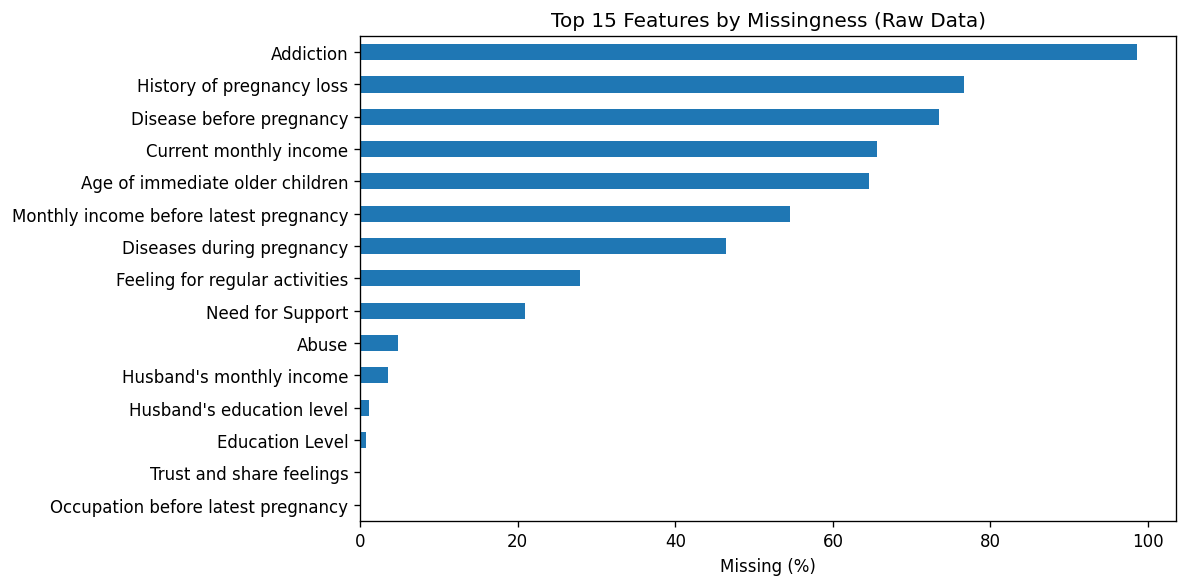

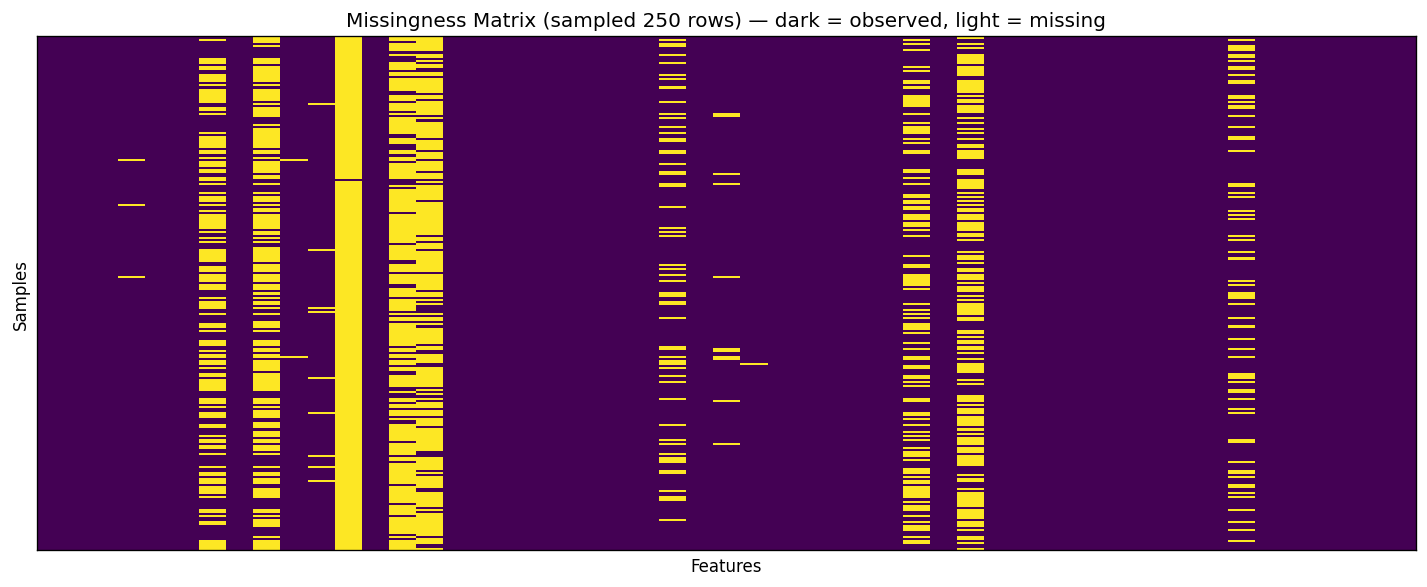

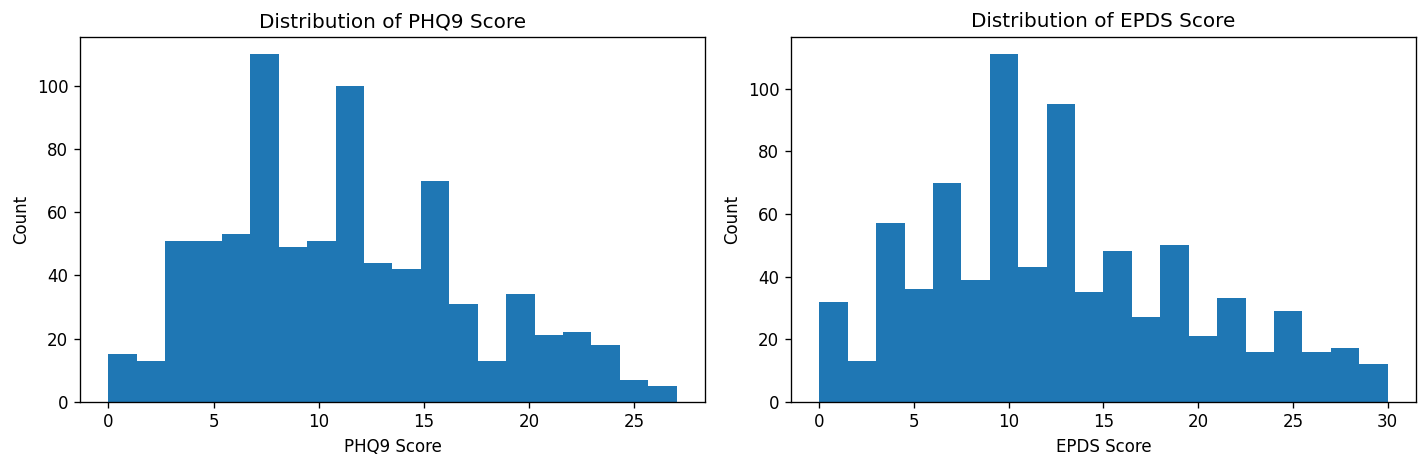

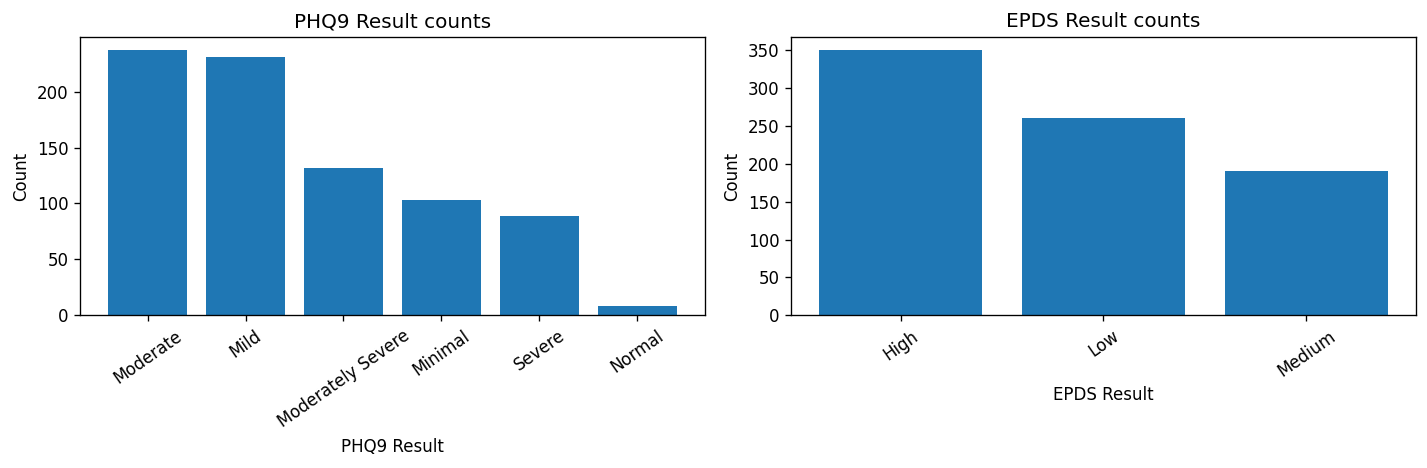

/tmp/ipykernel_55/850470604.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showfliers=False)


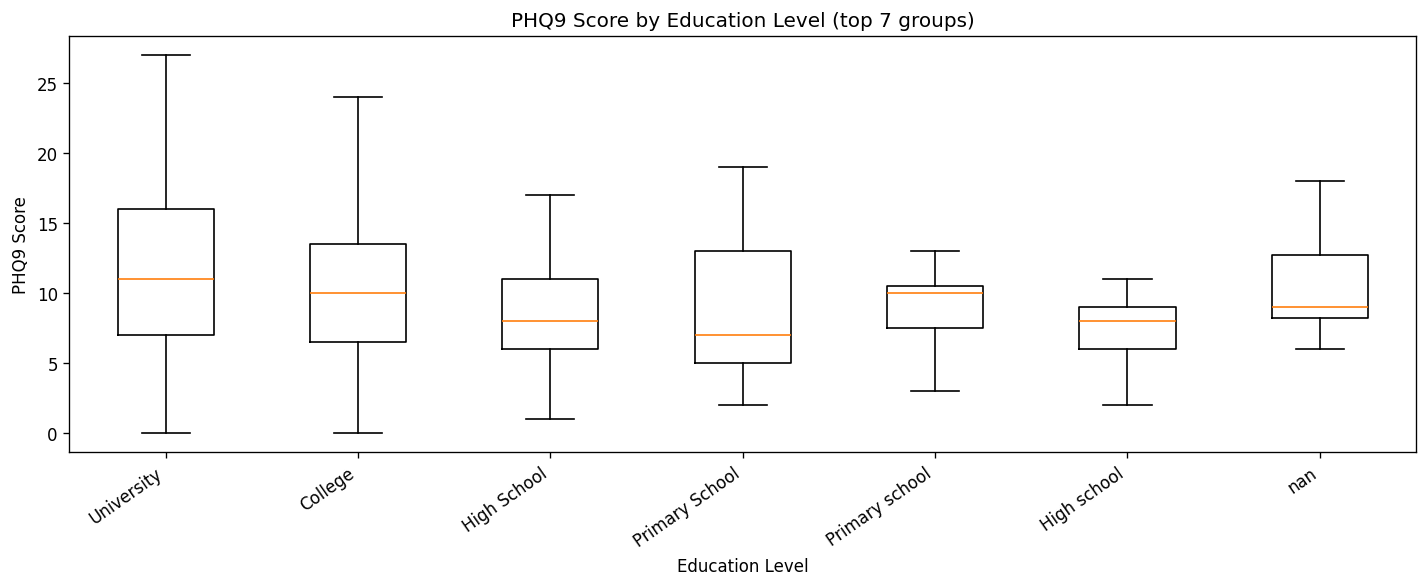

/tmp/ipykernel_55/850470604.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showfliers=False)


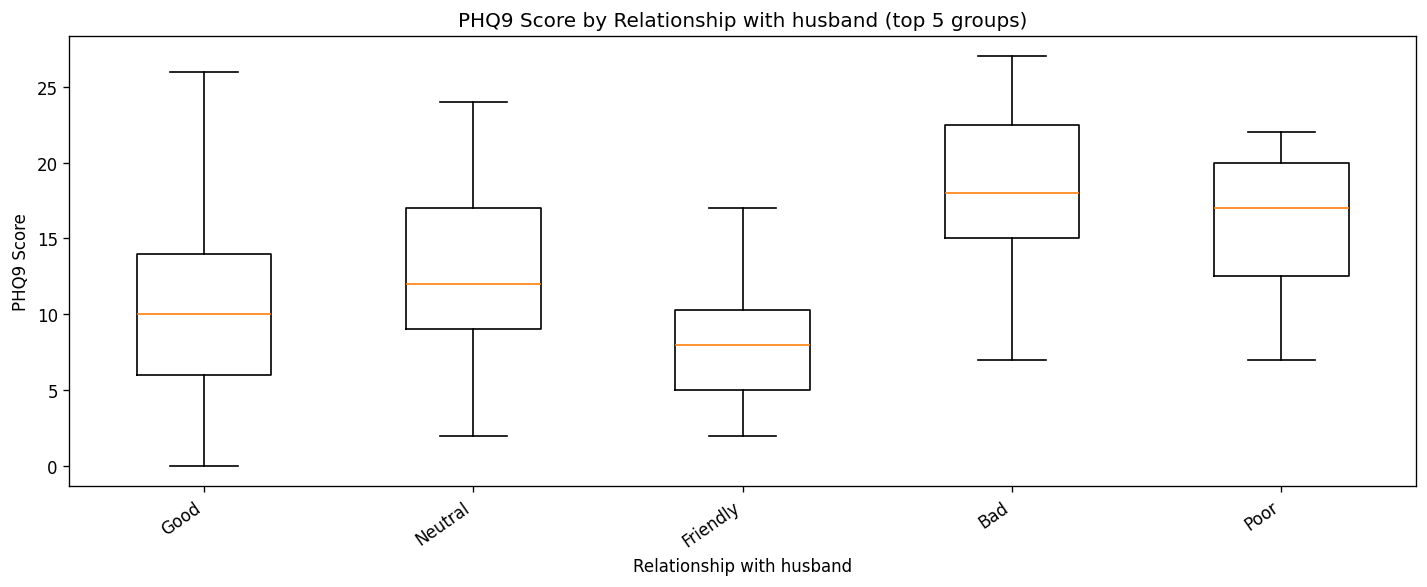

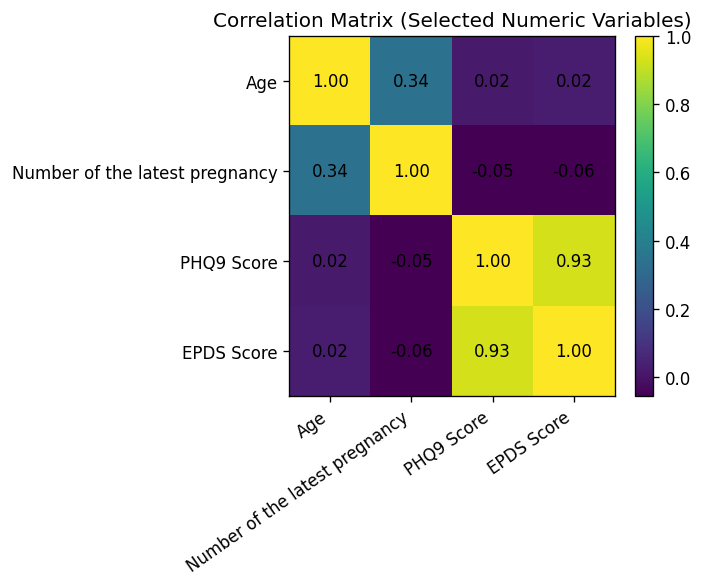

In [3]:
# =========================
# 2) EDA: Missingness + Score Distributions + Simple Associations
# =========================

# Load a *raw* copy for descriptive EDA (do NOT use this df for modeling)
df_full = pd.read_csv(DATA_PATH)

# Normalize column names (same hygiene as modeling)
df_full.columns = (
    df_full.columns.astype(str)
    .str.strip()
    .str.replace("\u2019", "'", regex=False)
    .str.replace("\u2018", "'", regex=False)
)

print(f"Raw dataset shape: {df_full.shape}")

# -------------------------
# 2.1 Missingness summary
# -------------------------
missing_counts = df_full.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df_full) * 100).round(2)

missing_table = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_%": missing_pct
})

print("\nMissing values (Top 15):")
display(missing_table.head(15))

# Bar plot: top missingness
top_k = 15
plt.figure(figsize=(10, 5))
missing_table.head(top_k).iloc[::-1]["missing_%"].plot(kind="barh")
plt.xlabel("Missing (%)")
plt.title(f"Top {top_k} Features by Missingness (Raw Data)")
plt.tight_layout()
plt.show()

# Missingness matrix (subsample rows for readability if needed)
sample_n = min(250, len(df_full))
df_miss = df_full.sample(sample_n, random_state=RANDOM_STATE)
plt.figure(figsize=(12, 5))
plt.imshow(df_miss.isna().to_numpy(), aspect="auto", interpolation="nearest")
plt.title(f"Missingness Matrix (sampled {sample_n} rows) — dark = observed, light = missing")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.yticks([])
plt.xticks([])  # too dense to label reliably
plt.tight_layout()
plt.show()

# -------------------------
# 2.2 Target-related descriptive analysis (PHQ9 & EPDS)
# -------------------------
score_cols = ["PHQ9 Score", "EPDS Score"]
result_cols = ["PHQ9 Result", "EPDS Result"]

# Histograms for scores (if available)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, col in zip(axes, score_cols):
    if col in df_full.columns:
        s = pd.to_numeric(df_full[col], errors="coerce").dropna()
        ax.hist(s, bins=20, density=False)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    else:
        ax.axis("off")
        ax.set_title(f"{col} not found")
plt.tight_layout()
plt.show()

# Severity label counts (if available)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, col in zip(axes, result_cols):
    if col in df_full.columns:
        vc = df_full[col].astype(str).str.strip().value_counts(dropna=False)
        ax.bar(vc.index.astype(str), vc.values)
        ax.set_title(f"{col} counts")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=35)
    else:
        ax.axis("off")
        ax.set_title(f"{col} not found")
plt.tight_layout()
plt.show()

# -------------------------
# 2.3 Simple demographic/social comparisons vs PHQ9 score (descriptive)
# -------------------------
def grouped_boxplot(df: pd.DataFrame, group_col: str, value_col: str, max_groups: int = 12):
    """Matplotlib boxplot grouped by a categorical column (top groups only for readability)."""
    if group_col not in df.columns or value_col not in df.columns:
        print(f"Skipping: '{group_col}' or '{value_col}' not found.")
        return

    tmp = df[[group_col, value_col]].copy()
    tmp[group_col] = tmp[group_col].astype(str).str.strip()
    tmp[value_col] = pd.to_numeric(tmp[value_col], errors="coerce")
    tmp = tmp.dropna()

    # Keep top groups by frequency (avoid unreadable plots)
    top_groups = tmp[group_col].value_counts().head(max_groups).index.tolist()
    tmp = tmp[tmp[group_col].isin(top_groups)]

    groups = [g for g in top_groups if (tmp[group_col] == g).any()]
    data = [tmp.loc[tmp[group_col] == g, value_col].values for g in groups]

    plt.figure(figsize=(12, 5))
    plt.boxplot(data, labels=groups, showfliers=False)
    plt.title(f"{value_col} by {group_col} (top {len(groups)} groups)")
    plt.xlabel(group_col)
    plt.ylabel(value_col)
    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.show()

grouped_boxplot(df_full, "Education Level", "PHQ9 Score", max_groups=12)
grouped_boxplot(df_full, "Relationship with husband", "PHQ9 Score", max_groups=10)

# -------------------------
# 2.4 Correlation among key numeric variables
# -------------------------
numerical_cols = ["Age", "Number of the latest pregnancy", "PHQ9 Score", "EPDS Score"]
available_num = [c for c in numerical_cols if c in df_full.columns]

if len(available_num) >= 2:
    num_df = df_full[available_num].apply(pd.to_numeric, errors="coerce")
    corr = num_df.corr()

    plt.figure(figsize=(6, 5))
    plt.imshow(corr.to_numpy(), interpolation="nearest", aspect="auto")
    plt.title("Correlation Matrix (Selected Numeric Variables)")
    plt.xticks(range(len(available_num)), available_num, rotation=35, ha="right")
    plt.yticks(range(len(available_num)), available_num)

    # annotate
    for i in range(len(available_num)):
        for j in range(len(available_num)):
            val = corr.iloc[i, j]
            if pd.notna(val):
                plt.text(j, i, f"{val:.2f}", ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns available for correlation plot.")


## 3. Domain Feature Grouping (DA-HSE)

DA-HSE requires partitioning the input feature space into **semantically meaningful domains**.  
We define four domains aligned with the proposal:

- **demo**: demographic and socioeconomic factors  
- **med**: obstetric and medical history  
- **social**: interpersonal support and social environment  
- **psych**: psychological/affective indicators  

To ensure robustness across minor dataset schema variations, we:
- **Validate** each listed feature against the actual columns present in `X_raw`
- **Auto-remove** missing features (with transparent logging)
- Report **final domain sizes** and ensure no domain is empty


In [4]:
# =========================
# 3) Domain Feature Grouping (DA-HSE)
# =========================

# Canonical domain definitions (edit here if dataset schema changes)
DOMAIN_MAP = {
    "demo": [
        "Age",
        "Residence",
        "Education Level",
        "Marital status",
        "Occupation before latest pregnancy",
        "Monthly income before latest pregnancy",
        "Occupation After Your Latest Childbirth",
        "Current monthly income",
        "Husband's education level",
        "Husband’s monthly income",
        "Family type",
        "Number of household members",
    ],
    "med": [
        "Addiction",
        "Total children",
        "Disease before pregnancy",
        "History of pregnancy loss",
        "Number of the latest pregnancy",
        "Pregnancy length",
        "Pregnancy plan",
        "Regular checkups",
        "Diseases during pregnancy",
        "Age of newborn",
        "Age of immediate older children",
        "Mode of delivery",
        "Gender of newborn",
        "Birth compliancy",
        "Breastfeed",
        "Newborn illness",
    ],
    "social": [
        "Relationship with the in-laws",
        "Relationship with husband",
        "Relationship with the newborn",
        "Relationship between father and newborn",
        "Feeling about motherhood",
        "Recieved Support",
        "Need for Support",
        "Major changes or losses during pregnancy",
        "Abuse",
        "Trust and share feelings",
        "Worry about newborn",
        "Relax/sleep when newborn is tended ",
        "Relax/sleep when the newborn is asleep",
    ],
    "psych": [
        "Fear of pregnancy",
        "Angry after latest child birth",
        "Feeling for regular activities",
        "Depression before pregnancy (PHQ2)",
        "Depression during pregnancy (PHQ2)",
    ],
}

# --- Validation against actual feature columns ---
domain_map: Dict[str, List[str]] = {}
all_features = set(X_raw.columns)

print("Domain feature validation:")
for domain, cols in DOMAIN_MAP.items():
    cols = list(dict.fromkeys(cols))  # de-duplicate while preserving order
    valid = [c for c in cols if c in all_features]
    missing = [c for c in cols if c not in all_features]

    if missing:
        print(f"  - [{domain}] removed missing columns ({len(missing)}): {missing}")

    domain_map[domain] = valid

# --- Basic sanity checks ---
empty_domains = [d for d, cols in domain_map.items() if len(cols) == 0]
if empty_domains:
    raise ValueError(
        f"The following domains became empty after validation: {empty_domains}. "
        "Please check column names or update DOMAIN_MAP."
    )

# Optional: check overlaps (a feature appearing in >1 domain)
feature_to_domains: Dict[str, List[str]] = {}
for d, cols in domain_map.items():
    for c in cols:
        feature_to_domains.setdefault(c, []).append(d)

overlaps = {f: ds for f, ds in feature_to_domains.items() if len(ds) > 1}
if overlaps:
    print("\nWarning: overlapping features across domains (review if unintended):")
    for f, ds in list(overlaps.items())[:25]:
        print(f"  - {f}: {ds}")

print("\nFinal domain sizes:")
for d, cols in domain_map.items():
    print(f"  {d}: {len(cols)} features")

print(f"\nTotal unique features across domains: {len(feature_to_domains)}")


Domain feature validation:
  - [demo] removed missing columns (1): ['Husband’s monthly income']
  - [social] removed missing columns (1): ['Relax/sleep when newborn is tended ']

Final domain sizes:
  demo: 11 features
  med: 16 features
  social: 12 features
  psych: 5 features

Total unique features across domains: 44


## 4. Leakage-Safe Preprocessing & Train-Only Resampling (Utilities)

To ensure **valid generalization**, *all* preprocessing and resampling must be fit **only on the training split / training fold**.

This cell defines:
1. **`LeakageSafePreprocessor`** — a scikit-learn compatible transformer that:
   - detects categorical vs numeric columns,
   - encodes categoricals using an `OrdinalEncoder`,
   - imputes missing values using `KNNImputer`,
   - and can be safely applied to validation/test folds without leaking information.

2. **`safe_resample_train`** — applies **SMOTE** when feasible, otherwise falls back to **RandomOverSampler**.  
   Resampling is **train-only** and should never be applied to test data.

These utilities support both **single split** experiments and **cross-validation** (fit inside each fold).


In [5]:
# =========================
# 4) Leakage-Safe Preprocessing + Train-Only Resampling
# =========================

from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE, RandomOverSampler


class LeakageSafePreprocessor(BaseEstimator, TransformerMixin):
    """
    Leakage-safe preprocessing transformer (train-fit only).

    Steps:
      1) Identify categorical columns via dtype == object/category.
      2) Ordinal-encode categoricals:
           - unknown categories in validation/test -> NaN (treated as missing)
           - missing categories -> NaN
      3) Convert all columns to numeric (coerce errors -> NaN)
      4) KNN-impute missing values using TRAIN statistics only.

    Why this design:
      - Prevents test information from influencing preprocessing parameters.
      - Unknown categories at inference are safely handled as missing and imputed.
    """

    def __init__(self, n_neighbors: int = 5):
        self.n_neighbors = n_neighbors

        # learned during fit
        self.columns_ = None
        self.categorical_cols_ = None
        self.numeric_cols_ = None
        self.encoder_ = None
        self.imputer_ = None

    def fit(self, X: pd.DataFrame, y=None):
        X = self._validate_input(X)
        self.columns_ = list(X.columns)

        # Identify categorical columns (robust to pandas category dtype)
        self.categorical_cols_ = list(
            X.select_dtypes(include=["object", "category"]).columns
        )
        self.numeric_cols_ = [c for c in self.columns_ if c not in self.categorical_cols_]

        # Fit encoder only on training categoricals (if any)
        if self.categorical_cols_:
            self.encoder_ = OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,          # <-- key: unknowns become missing
                encoded_missing_value=np.nan,  # missing stays missing
                dtype=np.float64,
            )
            self.encoder_.fit(X[self.categorical_cols_])

        # Encode + numeric coercion
        X_num = self._encode_to_numeric(X)

        # Fit imputer on training only
        self.imputer_ = KNNImputer(n_neighbors=self.n_neighbors)
        self.imputer_.fit(X_num)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.columns_ is None or self.imputer_ is None:
            raise RuntimeError("Preprocessor has not been fitted. Call fit() first.")

        X = self._validate_input(X)

        # Align columns to training schema (handles column order differences)
        X = X.reindex(columns=self.columns_, fill_value=np.nan)

        X_num = self._encode_to_numeric(X)
        X_imp = self.imputer_.transform(X_num)

        return pd.DataFrame(X_imp, columns=self.columns_, index=X.index)

    def _encode_to_numeric(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        if self.categorical_cols_:
            X[self.categorical_cols_] = self.encoder_.transform(X[self.categorical_cols_])

        # Force numeric across all columns; non-parsable -> NaN (imputable)
        X = X.apply(pd.to_numeric, errors="coerce")
        return X

    @staticmethod
    def _validate_input(X) -> pd.DataFrame:
        if not isinstance(X, pd.DataFrame):
            raise TypeError(f"Expected a pandas DataFrame, got {type(X)}")
        return X


def safe_resample_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.Series, str]:
    """
    Train-only resampling utility.

    - Uses SMOTE when the minority class has enough samples.
    - Falls back to RandomOverSampler when SMOTE is not feasible.
    - If only one class exists in y_train (edge case), returns data unchanged.

    Returns:
      X_res, y_res, strategy_name
    """
    y_train = pd.Series(y_train).astype(int)

    # Edge case: only one class present (cannot resample)
    if y_train.nunique() < 2:
        return X_train, y_train, "NoResampling(single-class)"

    class_counts = y_train.value_counts()
    minority = int(class_counts.min())

    # SMOTE requires at least k_neighbors + 1 minority samples
    # (default k_neighbors=5 => needs >=6)
    if minority >= 6:
        k = min(5, minority - 1)
        smote = SMOTE(random_state=random_state, k_neighbors=k)
        X_res, y_res = smote.fit_resample(X_train, y_train)
        return X_res, y_res, f"SMOTE(k_neighbors={k})"

    # Otherwise, safest fallback
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X_train, y_train)
    return X_res, y_res, "RandomOverSampler(fallback)"


## 5. Train/Test Split, Leakage-Safe Preprocessing, and Train-Only Resampling

To preserve **evaluation integrity**, we apply the following strict protocol:

1. **Split first** using a stratified train/test split (hold-out test set).
2. **Fit preprocessing only on the training set** (encoding + KNN imputation).
3. **Transform** validation/test sets using the fitted preprocessing objects (no refitting).
4. **Resample only the training set** to mitigate class imbalance (SMOTE if feasible; otherwise oversampling fallback).

We also optionally remove features with **extreme missingness** (e.g., >90%) *based on the training set only* to avoid unstable imputation.


In [6]:
# =========================
# 5) Split → Preprocess (train-fit only) → Resample (train only)
# =========================

from sklearn.model_selection import train_test_split

# --- 5.1 Hold-out split (split FIRST to prevent leakage) ---
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw,
    y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Hold-out split shapes:")
print(f"  X_train_raw: {X_train_raw.shape} | y_train: {y_train.shape}")
print(f"  X_test_raw : {X_test_raw.shape} | y_test : {y_test.shape}")

# --- 5.2 Optional: drop extremely sparse features (based on TRAIN only) ---
MISSINGNESS_DROP_THRESH = 0.90  # drop columns with >90% missing in TRAIN
train_missing_rate = X_train_raw.isna().mean()
drop_cols = train_missing_rate[train_missing_rate > MISSINGNESS_DROP_THRESH].index.tolist()

if drop_cols:
    X_train_raw = X_train_raw.drop(columns=drop_cols)
    X_test_raw  = X_test_raw.drop(columns=drop_cols)
    print(f"\nDropped {len(drop_cols)} features with >{int(MISSINGNESS_DROP_THRESH*100)}% missingness (train-only criterion).")
    print("Examples:", drop_cols[:10])
else:
    print(f"\nNo features exceeded {int(MISSINGNESS_DROP_THRESH*100)}% missingness threshold in training data.")

# --- 5.3 Leakage-safe preprocessing (fit on TRAIN only; transform both) ---
pre = LeakageSafePreprocessor(n_neighbors=5)
X_train = pre.fit_transform(X_train_raw)
X_test = pre.transform(X_test_raw)

# Sanity checks: imputation should remove NaNs
train_nans = int(np.isnan(X_train.to_numpy()).sum())
test_nans = int(np.isnan(X_test.to_numpy()).sum())

print("\nAfter preprocessing (leakage-safe):")
print(f"  Train NaNs remaining: {train_nans}")
print(f"  Test  NaNs remaining: {test_nans}")

if train_nans > 0 or test_nans > 0:
    print("Warning: NaNs remain after preprocessing. Consider increasing KNN neighbors or revisiting dtype coercions.")

# --- 5.4 Resample ONLY training set (never touch test set) ---
X_train_res, y_train_res, sampler_used = safe_resample_train(
    X_train, y_train, random_state=RANDOM_STATE
)

print("\nResampling strategy:", sampler_used)
print("Train after resampling:", X_train_res.shape)
print("Class distribution after resampling:", y_train_res.value_counts().to_dict())


Hold-out split shapes:
  X_train_raw: (640, 46) | y_train: (640,)
  X_test_raw : (160, 46) | y_test : (160,)

Dropped 1 features with >90% missingness (train-only criterion).
Examples: ['Addiction']

After preprocessing (leakage-safe):
  Train NaNs remaining: 0
  Test  NaNs remaining: 0

Resampling strategy: SMOTE(k_neighbors=5)
Train after resampling: (864, 45)
Class distribution after resampling: {0: 432, 1: 432}


## 6. Domain-wise Hyperparameter Tuning (XGBoost) — Leakage-Safe Cross-Validation

We tune an **XGBoost base learner per domain** using **Optuna** on the *training set only*.

Key research-grade safeguards:
- **No test-set usage** during tuning.
- **Fold-safe processing:** preprocessing + SMOTE happens **inside each CV fold** via an `imblearn` pipeline.
  This prevents data leakage that would occur if we SMOTE once globally before cross-validation.
- Objective: **minimize cross-validated log loss**, which rewards well-calibrated probability estimates.

Outputs:
- `best_params_per_domain`: dictionary of the best XGBoost hyperparameters for each domain.


In [7]:
# =========================
# 6) Optuna Tuning: Domain-wise XGBoost (Leakage-safe CV via Pipeline)
# =========================

import optuna
import numpy as np

from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import xgboost as xgb

# -------------------------
# Configuration
# -------------------------
N_TRIALS = 20
N_SPLITS = 3
OPTUNA_SEED = RANDOM_STATE

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Store best params per domain
best_params_per_domain = {}

# Helper: ensure domain columns exist after earlier train-only column dropping
def get_valid_domain_cols(domain: str, cols: list, X_ref) -> list:
    valid = [c for c in cols if c in X_ref.columns]
    missing = [c for c in cols if c not in X_ref.columns]
    if missing:
        print(f"  - [{domain}] missing columns ignored ({len(missing)}): {missing}")
    return valid

# CV splitter (train-fold shuffling fixed)
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

def make_objective(X_domain: pd.DataFrame, y_train: pd.Series):
    """
    Optuna objective bound to a specific domain's training data.

    Uses an imblearn Pipeline:
      LeakageSafePreprocessor -> SMOTE (or fallback ROS) -> XGBClassifier
    evaluated with Stratified K-Fold CV on *training* only.
    """
    y_train = pd.Series(y_train).astype(int)

    def objective(trial: optuna.Trial) -> float:
        # XGBoost hyperparameter search space (compact + effective)
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 600),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),

            # Fixed / reproducibility params
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "tree_method": "hist",
            "random_state": RANDOM_STATE,
            "n_jobs": -1,
            "verbosity": 0,
        }

        model = xgb.XGBClassifier(**params)

        # SMOTE is generally safe here given your class counts, but keep a fallback
        sampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

        pipe = ImbPipeline(steps=[
            ("pre", LeakageSafePreprocessor(n_neighbors=5)),
            ("sampler", sampler),
            ("model", model),
        ])

        try:
            scores = cross_val_score(
                pipe,
                X_domain,
                y_train,
                cv=cv,
                scoring="neg_log_loss",
                n_jobs=-1,
            )
            return float(-scores.mean())  # minimize logloss
        except ValueError:
            # Rare edge case: if a fold breaks SMOTE constraints, fall back to ROS
            pipe.set_params(sampler=RandomOverSampler(random_state=RANDOM_STATE))
            scores = cross_val_score(
                pipe,
                X_domain,
                y_train,
                cv=cv,
                scoring="neg_log_loss",
                n_jobs=-1,
            )
            return float(-scores.mean())

    return objective

print("=== Starting Hyperparameter Tuning (Domain-wise XGBoost) ===")

for domain, cols in domain_map.items():
    cols_valid = get_valid_domain_cols(domain, cols, X_train_raw)

    if len(cols_valid) == 0:
        print(f"\nSkipping domain '{domain}' (0 valid features after validation).")
        continue

    print(f"\nTuning domain: '{domain}' ({len(cols_valid)} features) | trials={N_TRIALS}, cv={N_SPLITS}-fold")

    X_domain_train = X_train_raw[cols_valid].copy()

    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler(seed=OPTUNA_SEED),
        pruner=MedianPruner(n_startup_trials=5),
    )

    study.optimize(make_objective(X_domain_train, y_train), n_trials=N_TRIALS)

    # Best hyperparameters for this domain
    best_params = dict(study.best_params)

    # Add fixed params used during training
    best_params.update({
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "verbosity": 0,
    })

    best_params_per_domain[domain] = {
        "params": best_params,
        "best_cv_logloss": float(study.best_value),
        "n_features": len(cols_valid),
        "features": cols_valid,
    }

    print(f"  -> Best CV LogLoss: {study.best_value:.4f}")
    print(f"  -> Best params: {study.best_params}")

print("\n=== Tuning complete. Results stored in `best_params_per_domain`. ===")


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


=== Starting Hyperparameter Tuning (Domain-wise XGBoost) ===

Tuning domain: 'demo' (11 features) | trials=20, cv=3-fold
  -> Best CV LogLoss: 0.6609
  -> Best params: {'n_estimators': 549, 'max_depth': 5, 'learning_rate': 0.07348024903419592, 'subsample': 0.9867601240041178, 'colsample_bytree': 0.6080041637319256, 'min_child_weight': 3.8136004298865602, 'gamma': 2.6981005340139883, 'reg_alpha': 0.6052391761275712, 'reg_lambda': 1.871220597592786}
  - [med] missing columns ignored (1): ['Addiction']

Tuning domain: 'med' (15 features) | trials=20, cv=3-fold
  -> Best CV LogLoss: 0.6540
  -> Best params: {'n_estimators': 473, 'max_depth': 2, 'learning_rate': 0.06740272962183849, 'subsample': 0.9994636029283407, 'colsample_bytree': 0.7874820875551368, 'min_child_weight': 6.2584065123328845, 'gamma': 0.9081932656466283, 'reg_alpha': 0.5201430655103585, 'reg_lambda': 4.855944246050173}

Tuning domain: 'social' (12 features) | trials=20, cv=3-fold
  -> Best CV LogLoss: 0.5606
  -> Best para

## 7. DA-HSE Model: Domain-Aware Hierarchical Stacking Ensemble

We implement the proposed **Domain-Aware Hierarchical Stacking Ensemble (DA-HSE)**:

**Stage 1 — Domain base learners**
- For each domain \( d \in \{\text{demo, med, social, psych}\} \), train an XGBoost classifier using only that domain’s features.

**Stage 2 — Meta learner**
- Convert each sample into a **domain risk vector**:
  \[
  r(x) = \left[p_{\text{demo}}(y=1|x),\, p_{\text{med}}(y=1|x),\, p_{\text{social}}(y=1|x),\, p_{\text{psych}}(y=1|x)\r]()


In [8]:
# =========================
# 7) DA-HSE: Domain-Aware Stacking Ensemble
# =========================

import xgboost as xgb

from typing import Dict, List, Optional, Union
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


class DomainAwareEnsemble(BaseEstimator, ClassifierMixin):
    """
    Domain-Aware Hierarchical Stacking Ensemble (DA-HSE)

    Parameters
    ----------
    domain_map : Dict[str, List[str]]
        Mapping from domain name -> list of feature columns in that domain.
    domain_params : Dict[str, dict]
        Mapping from domain name -> XGBoost params for that domain.
        Each dict must be directly consumable by xgb.XGBClassifier(**params).
    meta_learner : {"lr","dt"}
        Meta-learner on top of domain risk scores. "lr" is recommended.
    random_state : int
        Global seed for reproducibility.

    Notes
    -----
    - This class assumes X is already numeric and imputed (no missing values).
    - Base learners are trained on domain subsets; meta learner is trained on the
      stacked probability outputs (risk scores).
    """

    def __init__(
        self,
        domain_map: Dict[str, List[str]],
        domain_params: Dict[str, dict],
        meta_learner: str = "lr",
        random_state: int = 42,
    ):
        self.domain_map = domain_map
        self.domain_params = domain_params
        self.meta_learner = meta_learner
        self.random_state = random_state

        # learned during fit
        self.base_models_ = None
        self.meta_model_ = None
        self.domains_ = None

    def fit(self, X: pd.DataFrame, y: Union[pd.Series, np.ndarray]):
        X = self._validate_X(X)
        y = pd.Series(y).astype(int).values

        self.domains_ = list(self.domain_map.keys())

        # --- Initialize base learners (domain-specific XGB params) ---
        self.base_models_ = {}
        for d in self.domains_:
            if d not in self.domain_params:
                raise KeyError(f"Missing hyperparameters for domain '{d}' in domain_params.")
            self.base_models_[d] = xgb.XGBClassifier(**self.domain_params[d])

        # --- Train base learners ---
        for d, cols in self.domain_map.items():
            cols = self._validate_domain_cols(d, cols, X)
            self.base_models_[d].fit(X[cols], y)

        # --- Train meta learner on domain risk vectors ---
        X_meta = self._domain_risk_matrix(X)

        if self.meta_learner == "lr":
            self.meta_model_ = LogisticRegression(
                C=0.5,
                class_weight="balanced",
                max_iter=2000,
                random_state=self.random_state,
            )
        elif self.meta_learner == "dt":
            self.meta_model_ = DecisionTreeClassifier(
                max_depth=3,
                class_weight="balanced",
                random_state=self.random_state,
            )
        else:
            raise ValueError("meta_learner must be one of {'lr', 'dt'}")

        self.meta_model_.fit(X_meta, y)
        return self

    # -------------------------
    # Internals
    # -------------------------
    def _domain_risk_matrix(self, X: pd.DataFrame) -> np.ndarray:
        """Return stacked matrix of domain predicted probabilities (n_samples, n_domains)."""
        risks = []
        for d, cols in self.domain_map.items():
            cols = self._validate_domain_cols(d, cols, X)
            p = self.base_models_[d].predict_proba(X[cols])[:, 1]
            risks.append(p)
        return np.column_stack(risks)

    @staticmethod
    def _validate_X(X) -> pd.DataFrame:
        if not isinstance(X, pd.DataFrame):
            raise TypeError(f"Expected pandas DataFrame, got {type(X)}")
        return X

    @staticmethod
    def _validate_domain_cols(domain: str, cols: List[str], X: pd.DataFrame) -> List[str]:
        valid = [c for c in cols if c in X.columns]
        if len(valid) == 0:
            raise ValueError(f"Domain '{domain}' has 0 valid columns in X.")
        return valid

    # -------------------------
    # Public prediction API
    # -------------------------
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        if self.base_models_ is None or self.meta_model_ is None:
            raise RuntimeError("Model is not fitted. Call fit() first.")

        X = self._validate_X(X)
        X_meta = self._domain_risk_matrix(X)

        if hasattr(self.meta_model_, "predict_proba"):
            return self.meta_model_.predict_proba(X_meta)

        # Fallback: some classifiers only output class labels
        pred = self.meta_model_.predict(X_meta).astype(int)
        return np.column_stack([1 - pred, pred])

    def predict(self, X: pd.DataFrame, threshold: float = 0.5) -> np.ndarray:
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

    # -------------------------
    # Interpretability helpers
    # -------------------------
    def get_domain_contributions(self) -> Dict[str, float]:
        """
        Domain-level contributions from the meta learner.

        - LR: signed coefficients (positive => increases risk)
        - DT: feature importances (non-negative, relative)
        """
        if self.meta_model_ is None:
            raise RuntimeError("Model is not fitted. Call fit() first.")

        if self.meta_learner == "lr":
            weights = self.meta_model_.coef_.ravel().tolist()
        else:
            weights = self.meta_model_.feature_importances_.ravel().tolist()

        return dict(zip(self.domains_, weights))

    def get_risk_profiles(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Per-sample risk scores from each domain base model.
        Useful for phenotyping and slice-based error analysis.
        """
        X = self._validate_X(X)
        M = self._domain_risk_matrix(X)
        return pd.DataFrame(M, columns=self.domains_, index=X.index)


## 8. Train DA-HSE and Evaluate on the Held-Out Test Set

This cell trains the **Domain-Aware Hierarchical Stacking Ensemble (DA-HSE)** on the **training data only** (after leakage-safe preprocessing and train-only resampling), then evaluates on the **untouched test set**.

We report a **probability-based** evaluation (crucial for clinical risk modeling):
- ROC-AUC, PR-AUC, Accuracy, Balanced Accuracy
- Sensitivity (Recall), **Specificity**, F1
- Brier score (calibration quality)
- Confusion matrix
- Calibration curve
- Global **domain contributions** from the meta-learner


=== DA-HSE TEST PERFORMANCE (Hold-out, Leakage-safe) ===
          Accuracy: 0.7375
      Balanced Acc: 0.6759
           ROC-AUC: 0.7657
            PR-AUC: 0.8629
Sensitivity (Recall): 0.8519
       Specificity: 0.5000
                F1: 0.8142
             Brier: 0.1802

Confusion Matrix [TN FP; FN TP]:
[[26 26]
 [16 92]]


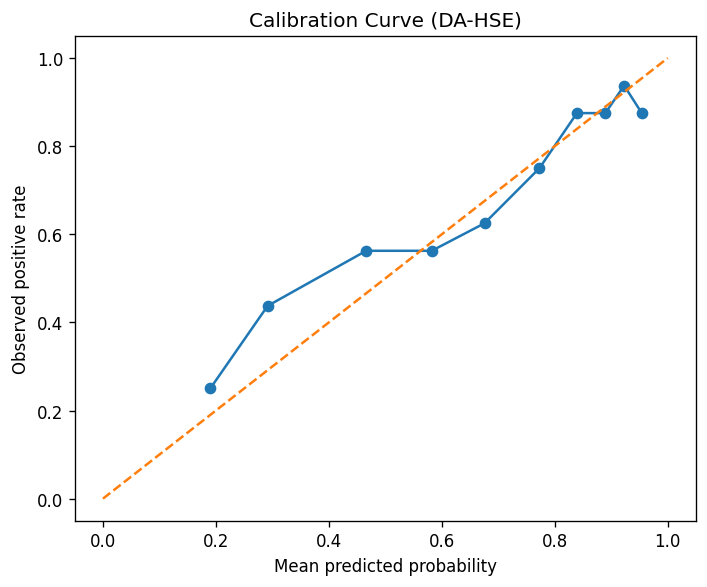

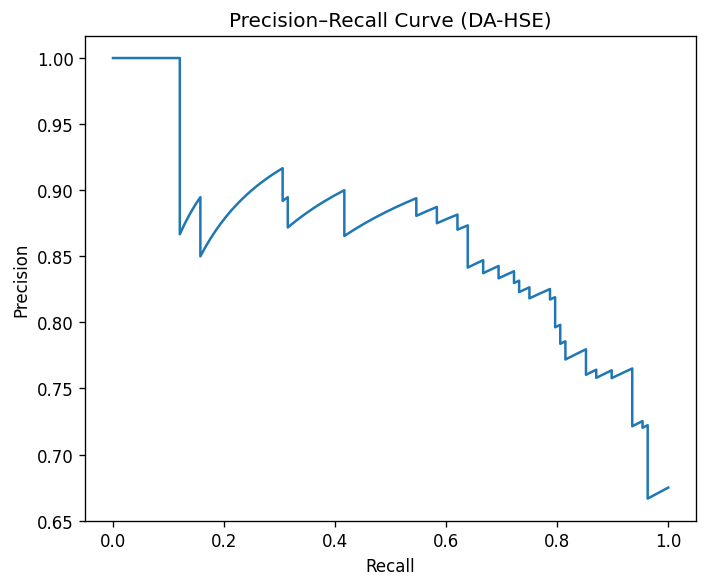


=== DOMAIN CONTRIBUTIONS (Meta-learner global weights) ===


,domain,weight
0,psych,2.909421
1,demo,2.847476
2,social,2.836637
3,med,2.599731


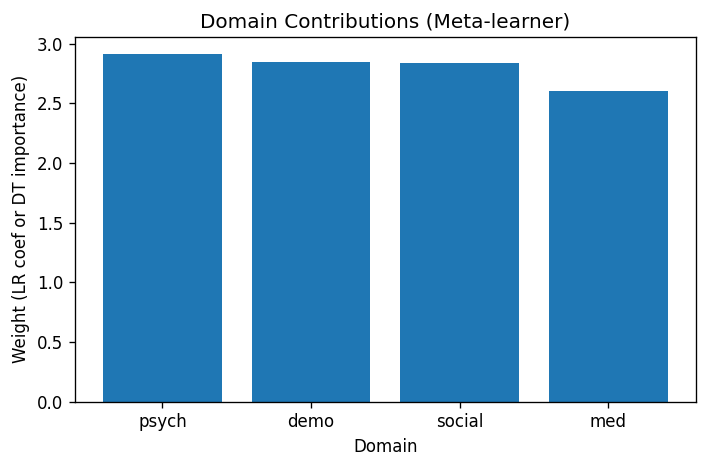

In [9]:
# =========================
# 8) Train + Evaluate DA-HSE (Hold-out Test)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score,
    average_precision_score, recall_score, f1_score,
    confusion_matrix, brier_score_loss, precision_recall_curve
)
from sklearn.calibration import calibration_curve

# --- 8.1 Build domain parameter dict (handles both nested and flat Optuna outputs) ---
domain_params = {}
for d in domain_map.keys():
    if d not in best_params_per_domain:
        raise KeyError(f"Missing best parameters for domain '{d}' in best_params_per_domain.")
    v = best_params_per_domain[d]
    domain_params[d] = v["params"] if isinstance(v, dict) and "params" in v else v  # <-- robust

# --- 8.2 Fit DA-HSE on training (resampled training only; test remains untouched) ---
da_hse = DomainAwareEnsemble(
    domain_map=domain_map,
    domain_params=domain_params,
    meta_learner="lr",
    random_state=RANDOM_STATE
)

da_hse.fit(X_train_res, y_train_res)

# --- 8.3 Predict probabilities on untouched test set ---
probs = da_hse.predict_proba(X_test)[:, 1]
threshold = 0.50
preds = (probs >= threshold).astype(int)

# --- 8.4 Metrics (includes Specificity + Calibration quality) ---
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

metrics = {
    "Accuracy": accuracy_score(y_test, preds),
    "Balanced Acc": balanced_accuracy_score(y_test, preds),
    "ROC-AUC": roc_auc_score(y_test, probs),
    "PR-AUC": average_precision_score(y_test, probs),
    "Sensitivity (Recall)": recall_score(y_test, preds),
    "Specificity": specificity,
    "F1": f1_score(y_test, preds),
    "Brier": brier_score_loss(y_test, probs),
}

print("=== DA-HSE TEST PERFORMANCE (Hold-out, Leakage-safe) ===")
for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

print("\nConfusion Matrix [TN FP; FN TP]:")
print(np.array([[tn, fp], [fn, tp]]))

# --- 8.5 Calibration curve (probability reliability) ---
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10, strategy="quantile")

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Calibration Curve (DA-HSE)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed positive rate")
plt.tight_layout()
plt.show()

# Optional: PR curve (useful under imbalance)
prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title("Precision–Recall Curve (DA-HSE)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# --- 8.6 Domain contributions (global interpretability) ---
contrib = da_hse.get_domain_contributions()
contrib_df = (
    pd.DataFrame({"domain": list(contrib.keys()), "weight": list(contrib.values())})
    .assign(abs_weight=lambda d: d["weight"].abs())
    .sort_values("abs_weight", ascending=False)
    .reset_index(drop=True)
)

print("\n=== DOMAIN CONTRIBUTIONS (Meta-learner global weights) ===")
display(contrib_df[["domain", "weight"]])

plt.figure(figsize=(6, 4))
plt.bar(contrib_df["domain"], contrib_df["weight"])
plt.title("Domain Contributions (Meta-learner)")
plt.xlabel("Domain")
plt.ylabel("Weight (LR coef or DT importance)")
plt.tight_layout()
plt.show()


## 9. Baselines + Comparative Evaluation

To contextualize DA-HSE performance, we evaluate three standard baselines on the **same held-out test set**:

1. **Flat Logistic Regression (LR)** — trained on all features (after leakage-safe preprocessing).
2. **Flat XGBoost (XGB)** — trained on all features.
3. **MDKR Stacking (DT + KNN + RF → MLP)** — a meta-learning baseline inspired by recent PPD literature (stacking with an MLP meta-learner).

All models are trained on the **training set only** (using the same preprocessed representation), and evaluated on the **untouched test set** using probability-based metrics (ROC-AUC, PR-AUC, Brier, etc.).


=== Comparative Results @ threshold=0.50 (Hold-out Test) ===


,Model,ROC-AUC,PR-AUC,Accuracy,Balanced Acc,Sensitivity,Specificity,F1,Brier,TN,FP,FN,TP
0,DA-HSE (Domain Stacking),0.7657,0.8629,0.7375,0.6759,0.8519,0.5000,0.8142,0.1802,26,26,16,92
1,MDKR Stacking (DT+KNN+RF→MLP),0.7605,0.8666,0.7312,0.6763,0.8333,0.5192,0.8072,0.1868,27,25,18,90
2,Flat XGBoost,0.7564,0.8658,0.7063,0.6428,0.8241,0.4615,0.7911,0.2043,24,28,19,89
3,Flat LR,0.7368,0.8648,0.6687,0.6599,0.6852,0.6346,0.7363,0.2170,33,19,34,74


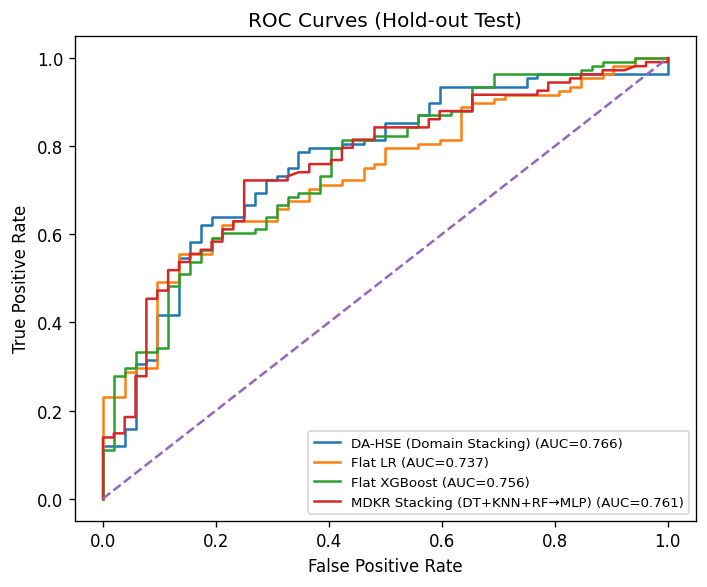

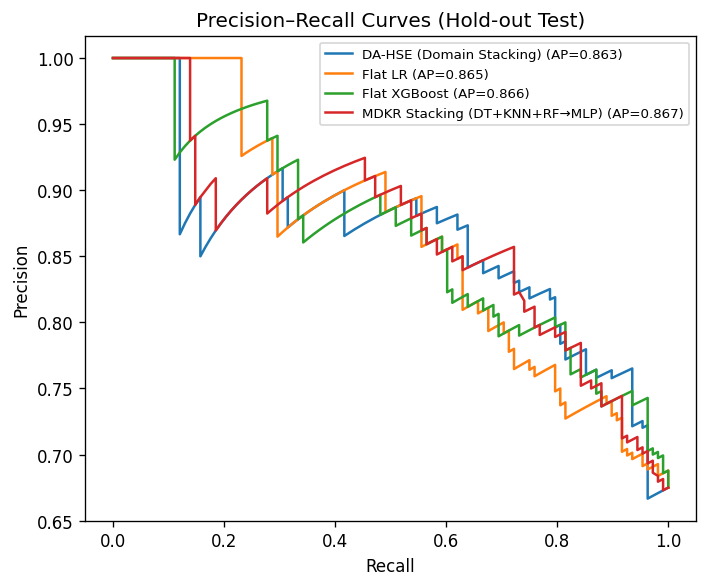

In [10]:
# =========================
# 9) Baselines + Comparison Table (DA-HSE vs Flat LR/XGB vs MDKR Stacking)
# =========================

from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix, brier_score_loss,
    roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


def compute_metrics(y_true, y_prob, threshold=0.5) -> dict:
    """Standardized metric set for all models."""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": average_precision_score(y_true, y_prob),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Sensitivity": recall_score(y_true, y_pred),
        "Specificity": specificity,
        "F1": f1_score(y_true, y_pred),
        "Brier": brier_score_loss(y_true, y_prob),
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
    }


# -------------------------
# 9.1 Ensure DA-HSE probabilities exist
# -------------------------
if "da_hse" not in globals():
    # Rebuild domain_params robustly if needed, then fit
    domain_params = {}
    for d in domain_map.keys():
        v = best_params_per_domain[d]
        domain_params[d] = v["params"] if isinstance(v, dict) and "params" in v else v

    da_hse = DomainAwareEnsemble(
        domain_map=domain_map,
        domain_params=domain_params,
        meta_learner="lr",
        random_state=RANDOM_STATE
    )
    da_hse.fit(X_train_res, y_train_res)

da_prob = da_hse.predict_proba(X_test)[:, 1]


# -------------------------
# 9.2 Baseline 1: Flat Logistic Regression (scaled)
# -------------------------
lr_flat = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])
lr_flat.fit(X_train_res, y_train_res)
lr_prob = lr_flat.predict_proba(X_test)[:, 1]


# -------------------------
# 9.3 Baseline 2: Flat XGBoost
# -------------------------
xgb_flat = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
)
xgb_flat.fit(X_train_res, y_train_res)
xgb_prob = xgb_flat.predict_proba(X_test)[:, 1]


# -------------------------
# 9.4 Baseline 3: MDKR Stacking (DT + KNN + RF → MLP)
#      (KNN wrapped with scaler; meta learner is MLP)
# -------------------------
estimators = [
    ("dt", DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=RANDOM_STATE)),
    ("knn", Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=7))
    ])),
    ("rf", RandomForestClassifier(
        n_estimators=400, class_weight="balanced",
        random_state=RANDOM_STATE, n_jobs=-1
    )),
]

mdkr = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        alpha=1e-4,
        max_iter=2000,
        random_state=RANDOM_STATE
    ),
    stack_method="predict_proba",
    passthrough=False,
    cv=5,
    n_jobs=-1
)

mdkr.fit(X_train_res, y_train_res)
mdkr_prob = mdkr.predict_proba(X_test)[:, 1]


# -------------------------
# 9.5 Aggregate results
# -------------------------
threshold = 0.50

probs_by_model = {
    "DA-HSE (Domain Stacking)": da_prob,
    "Flat LR": lr_prob,
    "Flat XGBoost": xgb_prob,
    "MDKR Stacking (DT+KNN+RF→MLP)": mdkr_prob,
}

results = []
for name, p in probs_by_model.items():
    row = {"Model": name, **compute_metrics(y_test, p, threshold=threshold)}
    results.append(row)

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False).reset_index(drop=True)

print(f"=== Comparative Results @ threshold={threshold:.2f} (Hold-out Test) ===")
display(results_df[[
    "Model", "ROC-AUC", "PR-AUC", "Accuracy", "Balanced Acc",
    "Sensitivity", "Specificity", "F1", "Brier", "TN", "FP", "FN", "TP"
]].style.format({
    "ROC-AUC": "{:.4f}",
    "PR-AUC": "{:.4f}",
    "Accuracy": "{:.4f}",
    "Balanced Acc": "{:.4f}",
    "Sensitivity": "{:.4f}",
    "Specificity": "{:.4f}",
    "F1": "{:.4f}",
    "Brier": "{:.4f}",
}))


# -------------------------
# 9.6 ROC + PR curves (publication-friendly)
# -------------------------
plt.figure(figsize=(6, 5))
for name, p in probs_by_model.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, p):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves (Hold-out Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
for name, p in probs_by_model.items():
    prec, rec, _ = precision_recall_curve(y_test, p)
    plt.plot(rec, prec, label=f"{name} (AP={average_precision_score(y_test, p):.3f})")
plt.title("Precision–Recall Curves (Hold-out Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


## 10. Within-Domain Interpretability (SHAP) for a Base Learner

We explain feature effects **within a chosen domain** using XGBoost’s SHAP-style contributions
(`pred_contribs=True`). This provides feature-level interpretability complementary to the
meta-learner’s domain weights.


In [11]:
domain_map_aligned = {}
print("Aligning domain_map to available features...")

for d, cols in domain_map.items():
    valid = [c for c in cols if c in X_train.columns]  # X_train/X_test share same columns now
    missing = [c for c in cols if c not in X_train.columns]
    if missing:
        print(f"  - [{d}] removed missing columns ({len(missing)}): {missing}")
    domain_map_aligned[d] = valid

# Replace domain_map with aligned version for downstream use
domain_map = domain_map_aligned

print("\nFinal aligned domain sizes:")
for d, cols in domain_map.items():
    print(f"  {d}: {len(cols)} features")

Aligning domain_map to available features...
  - [med] removed missing columns (1): ['Addiction']

Final aligned domain sizes:
  demo: 11 features
  med: 15 features
  social: 12 features
  psych: 5 features


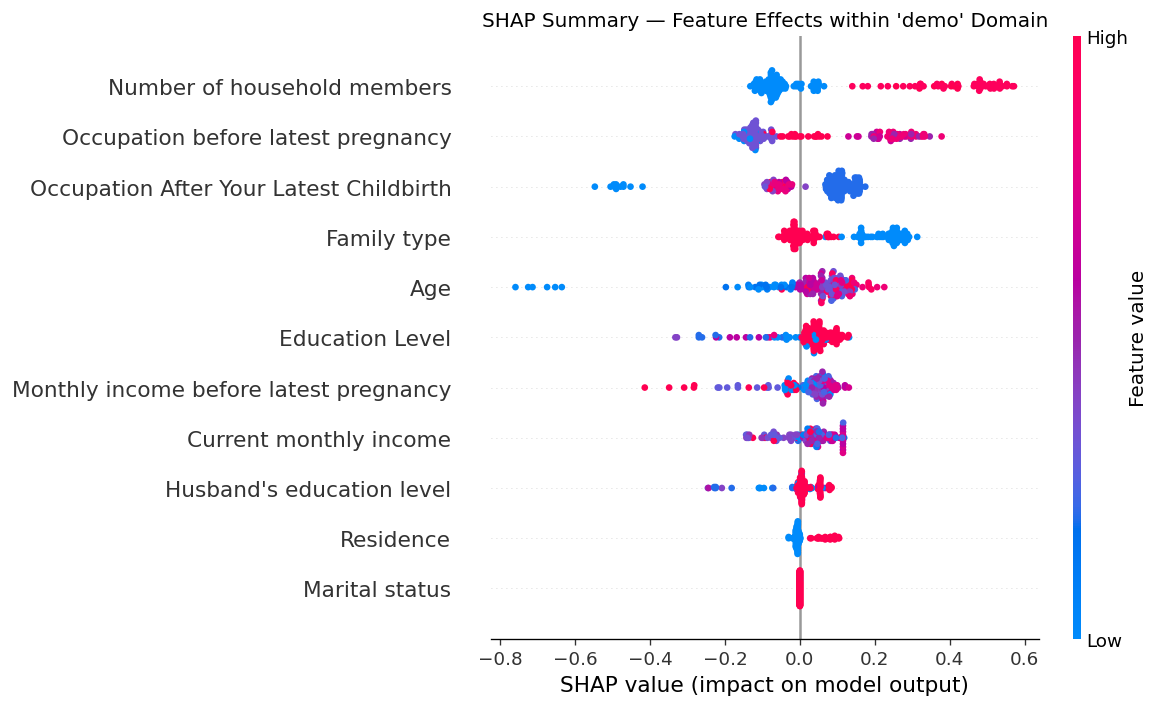

In [14]:
# =========================
# 10.1 SHAP within a domain (XGBoost base learner) — standalone & robust
# =========================

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

target_domain = "demo"  # "demo", "med", "social", "psych"

# Use aligned domain_map
cols = domain_map.get(target_domain, [])
if len(cols) == 0:
    raise ValueError(f"Domain '{target_domain}' has 0 features available. Check domain_map alignment.")

# Subset the test data to the domain
X_domain = X_test[cols].copy()

# Subsample rows for speed/readability
n_show = min(300, len(X_domain))
X_domain_vis = (
    X_domain.sample(n=n_show, random_state=RANDOM_STATE)
    if len(X_domain) > n_show else X_domain
)

# Build booster + DMatrix for THIS domain
booster = da_hse.base_models_[target_domain].get_booster()
dm = xgb.DMatrix(X_domain_vis, feature_names=list(X_domain_vis.columns))

# XGBoost native SHAP contributions: (n_samples, n_features + 1 bias)
contrib = booster.predict(dm, pred_contribs=True)
shap_values = contrib[:, :-1]  # last column = bias term

try:
    import shap

    shap.summary_plot(shap_values, X_domain_vis, show=False)
    plt.gcf().set_size_inches(10, 6)
    plt.title(f"SHAP Summary — Feature Effects within '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("SHAP plotting unavailable. Falling back to XGBoost feature importance (gain).")
    print("Reason:", str(e))

    ax = xgb.plot_importance(
        da_hse.base_models_[target_domain],
        importance_type="gain",
        max_num_features=15
    )
    ax.set_title(f"XGBoost Feature Importance (gain) — '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()


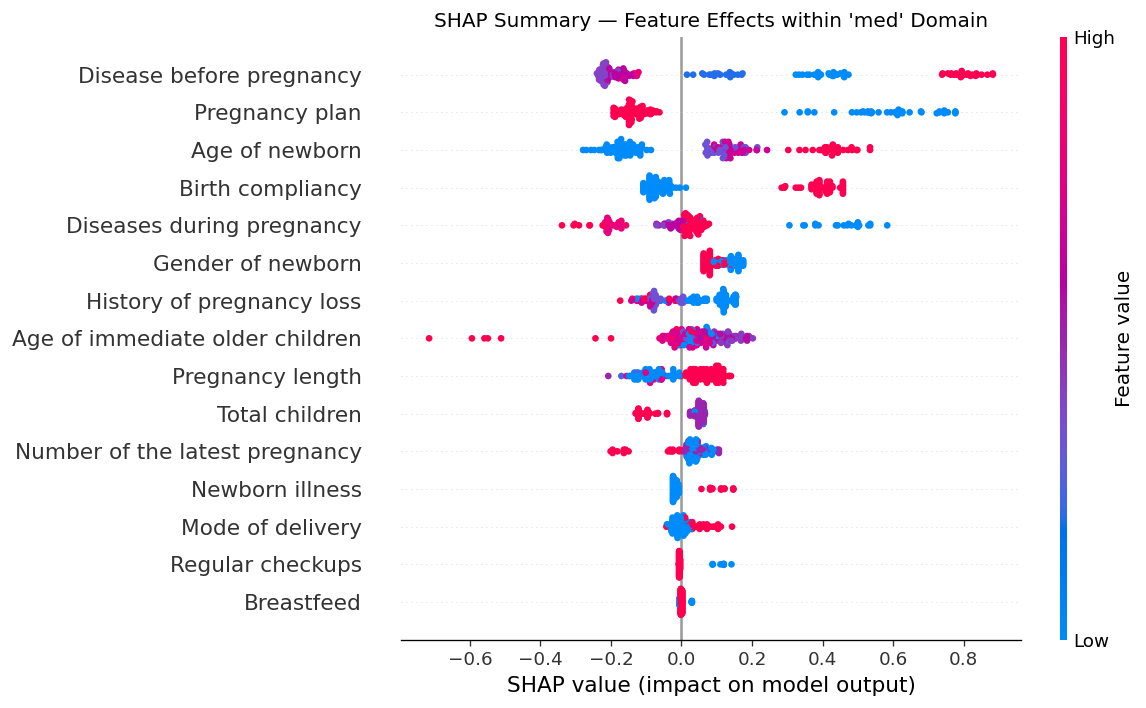

In [15]:
# =========================
# 10.2 SHAP within a domain (XGBoost base learner) — standalone & robust
# =========================

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

target_domain = "med"  # "demo", "med", "social", "psych"

# Use aligned domain_map
cols = domain_map.get(target_domain, [])
if len(cols) == 0:
    raise ValueError(f"Domain '{target_domain}' has 0 features available. Check domain_map alignment.")

# Subset the test data to the domain
X_domain = X_test[cols].copy()

# Subsample rows for speed/readability
n_show = min(300, len(X_domain))
X_domain_vis = (
    X_domain.sample(n=n_show, random_state=RANDOM_STATE)
    if len(X_domain) > n_show else X_domain
)

# Build booster + DMatrix for THIS domain
booster = da_hse.base_models_[target_domain].get_booster()
dm = xgb.DMatrix(X_domain_vis, feature_names=list(X_domain_vis.columns))

# XGBoost native SHAP contributions: (n_samples, n_features + 1 bias)
contrib = booster.predict(dm, pred_contribs=True)
shap_values = contrib[:, :-1]  # last column = bias term

try:
    import shap

    shap.summary_plot(shap_values, X_domain_vis, show=False)
    plt.gcf().set_size_inches(10, 6)
    plt.title(f"SHAP Summary — Feature Effects within '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("SHAP plotting unavailable. Falling back to XGBoost feature importance (gain).")
    print("Reason:", str(e))

    ax = xgb.plot_importance(
        da_hse.base_models_[target_domain],
        importance_type="gain",
        max_num_features=15
    )
    ax.set_title(f"XGBoost Feature Importance (gain) — '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()


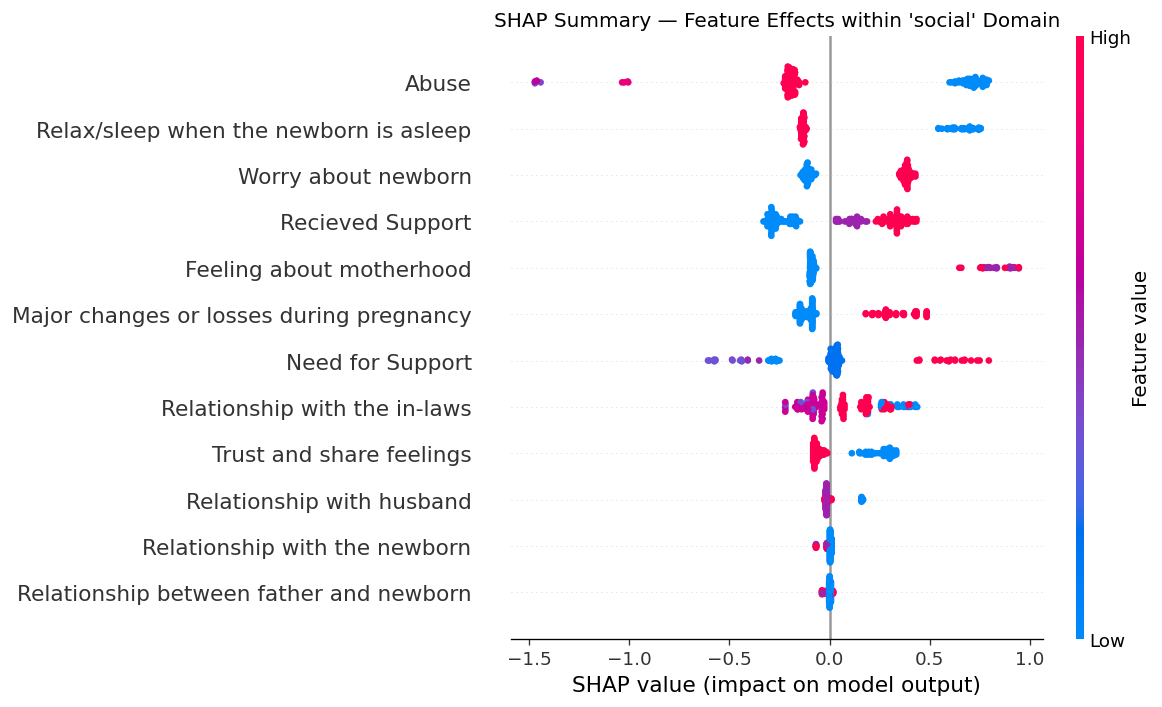

In [16]:
# =========================
# 10.3 SHAP within a domain (XGBoost base learner) — standalone & robust
# =========================

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

target_domain = "social"  # "demo", "med", "social", "psych"

# Use aligned domain_map
cols = domain_map.get(target_domain, [])
if len(cols) == 0:
    raise ValueError(f"Domain '{target_domain}' has 0 features available. Check domain_map alignment.")

# Subset the test data to the domain
X_domain = X_test[cols].copy()

# Subsample rows for speed/readability
n_show = min(300, len(X_domain))
X_domain_vis = (
    X_domain.sample(n=n_show, random_state=RANDOM_STATE)
    if len(X_domain) > n_show else X_domain
)

# Build booster + DMatrix for THIS domain
booster = da_hse.base_models_[target_domain].get_booster()
dm = xgb.DMatrix(X_domain_vis, feature_names=list(X_domain_vis.columns))

# XGBoost native SHAP contributions: (n_samples, n_features + 1 bias)
contrib = booster.predict(dm, pred_contribs=True)
shap_values = contrib[:, :-1]  # last column = bias term

try:
    import shap

    shap.summary_plot(shap_values, X_domain_vis, show=False)
    plt.gcf().set_size_inches(10, 6)
    plt.title(f"SHAP Summary — Feature Effects within '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("SHAP plotting unavailable. Falling back to XGBoost feature importance (gain).")
    print("Reason:", str(e))

    ax = xgb.plot_importance(
        da_hse.base_models_[target_domain],
        importance_type="gain",
        max_num_features=15
    )
    ax.set_title(f"XGBoost Feature Importance (gain) — '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()


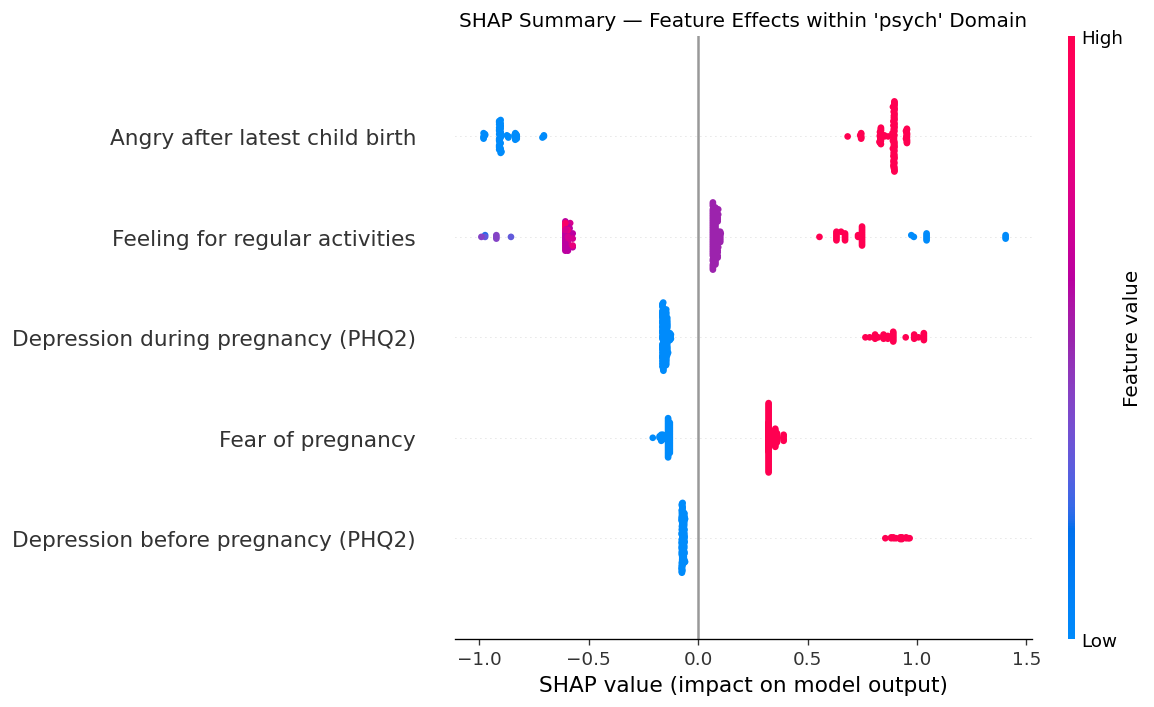

In [17]:
# =========================
# 10.1 SHAP within a domain (XGBoost base learner) — standalone & robust
# =========================

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

target_domain = "psych"  # "demo", "med", "social", "psych"

# Use aligned domain_map
cols = domain_map.get(target_domain, [])
if len(cols) == 0:
    raise ValueError(f"Domain '{target_domain}' has 0 features available. Check domain_map alignment.")

# Subset the test data to the domain
X_domain = X_test[cols].copy()

# Subsample rows for speed/readability
n_show = min(300, len(X_domain))
X_domain_vis = (
    X_domain.sample(n=n_show, random_state=RANDOM_STATE)
    if len(X_domain) > n_show else X_domain
)

# Build booster + DMatrix for THIS domain
booster = da_hse.base_models_[target_domain].get_booster()
dm = xgb.DMatrix(X_domain_vis, feature_names=list(X_domain_vis.columns))

# XGBoost native SHAP contributions: (n_samples, n_features + 1 bias)
contrib = booster.predict(dm, pred_contribs=True)
shap_values = contrib[:, :-1]  # last column = bias term

try:
    import shap

    shap.summary_plot(shap_values, X_domain_vis, show=False)
    plt.gcf().set_size_inches(10, 6)
    plt.title(f"SHAP Summary — Feature Effects within '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("SHAP plotting unavailable. Falling back to XGBoost feature importance (gain).")
    print("Reason:", str(e))

    ax = xgb.plot_importance(
        da_hse.base_models_[target_domain],
        importance_type="gain",
        max_num_features=15
    )
    ax.set_title(f"XGBoost Feature Importance (gain) — '{target_domain}' Domain")
    plt.tight_layout()
    plt.show()


## 11. Ablation Study (Domain Contribution)

We evaluate DA-HSE under **domain removal** to quantify each domain’s contribution.
For each domain \(d\), we re-train DA-HSE without \(d\) and report the change in:
- ROC-AUC (discrimination)
- PR-AUC (performance under imbalance)
- F1 (thresholded utility)

This provides an interpretable justification for the domain-wise design.


In [18]:
# =========================
# 11) Ablation Study (drop one domain at a time)
# =========================

import pandas as pd
from IPython.display import display

# Ensure params are in the expected format: domain -> param dict
domain_params = {
    d: (best_params_per_domain[d]["params"] if isinstance(best_params_per_domain[d], dict) and "params" in best_params_per_domain[d]
        else best_params_per_domain[d])
    for d in domain_map.keys()
}

def eval_quick(y_true, y_prob, threshold=0.5):
    m = compute_metrics(y_true, y_prob, threshold=threshold)
    return {
        "ROC-AUC": m["ROC-AUC"],
        "PR-AUC": m["PR-AUC"],
        "F1": m["F1"],
        "Accuracy": m["Accuracy"],
        "Specificity": m.get("Specificity", np.nan),
        "Sensitivity": m.get("Sensitivity", np.nan),
    }

print("=== ABLATION STUDY (Hold-out Test, retrain each variant) ===")

# Full model metrics
full_probs = da_hse.predict_proba(X_test)[:, 1]
full_m = eval_quick(y_test, full_probs)

rows = []
rows.append({"Setting": "Full DA-HSE", **full_m})

# Drop one domain at a time
for drop_domain in list(domain_map.keys()):
    reduced_map = {d: cols for d, cols in domain_map.items() if d != drop_domain}
    reduced_params = {d: domain_params[d] for d in reduced_map.keys()}  # keep only required params

    reduced_model = DomainAwareEnsemble(
        domain_map=reduced_map,
        domain_params=reduced_params,
        meta_learner="lr",
        random_state=RANDOM_STATE
    )
    reduced_model.fit(X_train_res, y_train_res)

    r_probs = reduced_model.predict_proba(X_test)[:, 1]
    r_m = eval_quick(y_test, r_probs)

    rows.append({
        "Setting": f"Drop: {drop_domain}",
        **r_m,
        "ΔROC-AUC": full_m["ROC-AUC"] - r_m["ROC-AUC"],
        "ΔPR-AUC": full_m["PR-AUC"] - r_m["PR-AUC"],
        "ΔF1": full_m["F1"] - r_m["F1"],
    })

ablation_df = pd.DataFrame(rows)

# Nice ordering: show drops by biggest ROC-AUC impact
drop_only = ablation_df[ablation_df["Setting"].str.startswith("Drop")].copy()
drop_only = drop_only.sort_values("ΔROC-AUC", ascending=False)

final_table = pd.concat([ablation_df.iloc[[0]], drop_only], ignore_index=True)

display(final_table.style.format({
    "ROC-AUC": "{:.4f}",
    "PR-AUC": "{:.4f}",
    "F1": "{:.4f}",
    "Accuracy": "{:.4f}",
    "Sensitivity": "{:.4f}",
    "Specificity": "{:.4f}",
    "ΔROC-AUC": "{:.4f}",
    "ΔPR-AUC": "{:.4f}",
    "ΔF1": "{:.4f}",
}))


=== ABLATION STUDY (Hold-out Test, retrain each variant) ===


,Setting,ROC-AUC,PR-AUC,F1,Accuracy,Specificity,Sensitivity,ΔROC-AUC,ΔPR-AUC,ΔF1
0,Full DA-HSE,0.7657,0.8629,0.8142,0.7375,0.5000,0.8519,nan,nan,nan
1,Drop: social,0.7000,0.8008,0.7965,0.7125,0.4615,0.8333,0.0657,0.0621,0.0177
2,Drop: psych,0.7301,0.8460,0.7982,0.7125,0.4423,0.8426,0.0356,0.0169,0.0159
3,Drop: demo,0.7715,0.8756,0.8091,0.7375,0.5577,0.8241,-0.0059,-0.0127,0.0051
4,Drop: med,0.7835,0.8813,0.8072,0.7312,0.5192,0.8333,-0.0178,-0.0184,0.0070


## 12. Evaluation with Out-of-Fold (OOF) Cross-Validation + 95% Confidence Intervals

In addition to the held-out test split, we optionally report a **robustness check** using
**Stratified K-Fold cross-validation** on the full dataset.

**Why OOF CV?**
- Each sample receives a prediction from a model that **did not train on that sample** (out-of-fold),
  reducing optimistic bias compared to in-sample evaluation.
- This provides a more stable estimate of discrimination performance, especially on moderate-sized datasets.

**Leakage-safe protocol (per fold):**
1. Split into train/validation folds.
2. Fit preprocessing (encoding + KNN imputation) **only on the fold-train data**.
3. Apply resampling (SMOTE/oversampling) **only on the fold-train data**.
4. Train the model on the resampled fold-train set.
5. Predict probabilities on the untouched fold-validation set to form OOF predictions.

**Uncertainty estimation:**
- We compute **bootstrap 95% confidence intervals** for ROC-AUC using the OOF predictions.



In [19]:
# =========================
# 12) OOF CV + Bootstrap CI (Leakage-safe)
# =========================

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier


drop_cols = drop_cols if "drop_cols" in globals() else []
X_raw_cv = X_raw.drop(columns=drop_cols, errors="ignore").copy()

# ---- 1) Clean domain_params ----
domain_params_clean = {
    d: (best_params_per_domain[d]["params"] if isinstance(best_params_per_domain[d], dict) and "params" in best_params_per_domain[d]
        else best_params_per_domain[d])
    for d in domain_map.keys()
}

# ---- 2) OOF prediction function ----
def oof_predictions(model_builder, X_raw_in, y_in, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof = np.zeros(len(X_raw_in), dtype=float)

    y_in = pd.Series(y_in).astype(int).reset_index(drop=True)
    X_raw_in = X_raw_in.reset_index(drop=True)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_raw_in, y_in), start=1):
        X_tr_raw, X_va_raw = X_raw_in.iloc[tr_idx], X_raw_in.iloc[va_idx]
        y_tr, y_va = y_in.iloc[tr_idx], y_in.iloc[va_idx]

        # Fit preprocess ONLY on fold-train
        pre = LeakageSafePreprocessor(n_neighbors=5)
        X_tr = pre.fit_transform(X_tr_raw)
        X_va = pre.transform(X_va_raw)

        # Resample ONLY fold-train
        X_tr_res, y_tr_res, _ = safe_resample_train(X_tr, y_tr, random_state=random_state)

        # Train and predict fold-valid
        model = model_builder()
        model.fit(X_tr_res, y_tr_res)
        oof[va_idx] = model.predict_proba(X_va)[:, 1]

        print(f"Fold {fold}/{n_splits} done.")

    return oof

# ---- 3) Bootstrap CI helper (for OOF scores) ----
def bootstrap_ci(y_true, y_score, metric_fn, n_boot=1000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_score[idx]))

    lo = np.quantile(stats, alpha / 2)
    hi = np.quantile(stats, 1 - alpha / 2)
    return float(lo), float(hi)

# ---- 4) Builders ----
def build_da():
    return DomainAwareEnsemble(
        domain_map=domain_map,                 
        domain_params=domain_params_clean,     
        meta_learner="lr",
        random_state=RANDOM_STATE
    )

def build_rf():
    return RandomForestClassifier(
        n_estimators=400,
        max_depth=12,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    )

# ---- 5) Run OOF ----
print("=== OOF CV: DA-HSE ===")
da_oof = oof_predictions(build_da, X_raw_cv, y, n_splits=5, random_state=RANDOM_STATE)

print("\n=== OOF CV: Flat RF ===")
rf_oof = oof_predictions(build_rf, X_raw_cv, y, n_splits=5, random_state=RANDOM_STATE)

# ---- 6) Metrics + CI ----
da_auc = roc_auc_score(y, da_oof)
rf_auc = roc_auc_score(y, rf_oof)

da_ci = bootstrap_ci(y, da_oof, lambda yt, ys: roc_auc_score(yt, ys))
rf_ci = bootstrap_ci(y, rf_oof, lambda yt, ys: roc_auc_score(yt, ys))

res_df = pd.DataFrame([
    {"Model": "DA-HSE (OOF)", "AUC": da_auc, "CI_low": da_ci[0], "CI_high": da_ci[1]},
    {"Model": "Flat RF (OOF)", "AUC": rf_auc, "CI_low": rf_ci[0], "CI_high": rf_ci[1]},
])

print("\n=== CV RESULTS (OOF + 95% CI) ===")
display(res_df.style.format({"AUC": "{:.4f}", "CI_low": "{:.4f}", "CI_high": "{:.4f}"}))


=== OOF CV: DA-HSE ===
Fold 1/5 done.
Fold 2/5 done.
Fold 3/5 done.
Fold 4/5 done.
Fold 5/5 done.

=== OOF CV: Flat RF ===
Fold 1/5 done.
Fold 2/5 done.
Fold 3/5 done.
Fold 4/5 done.
Fold 5/5 done.

=== CV RESULTS (OOF + 95% CI) ===


,Model,AUC,CI_low,CI_high
0,DA-HSE (OOF),0.8184,0.7887,0.8478
1,Flat RF (OOF),0.8072,0.7741,0.8365


## 13. Probability Calibration Comparison (Reliability Diagram + Brier Score)

For clinical risk prediction, probability outputs should be **well-calibrated** (i.e., a predicted risk of 0.70 should correspond to ~70% observed positives).

In this section we compare **DA-HSE** against a chosen baseline (e.g., Flat XGBoost) using:
- **Brier score** (lower is better): measures the mean squared error of predicted probabilities.
- **Calibration curve / reliability diagram**: compares mean predicted risk to observed event rates.

We use **quantile binning** (equal-count bins) to improve stability on moderate test set sizes.


=== CALIBRATION (TEST) ===
Brier (DA-HSE):   0.1802  (lower is better)
Brier (Flat XGBoost): 0.2043  (lower is better)


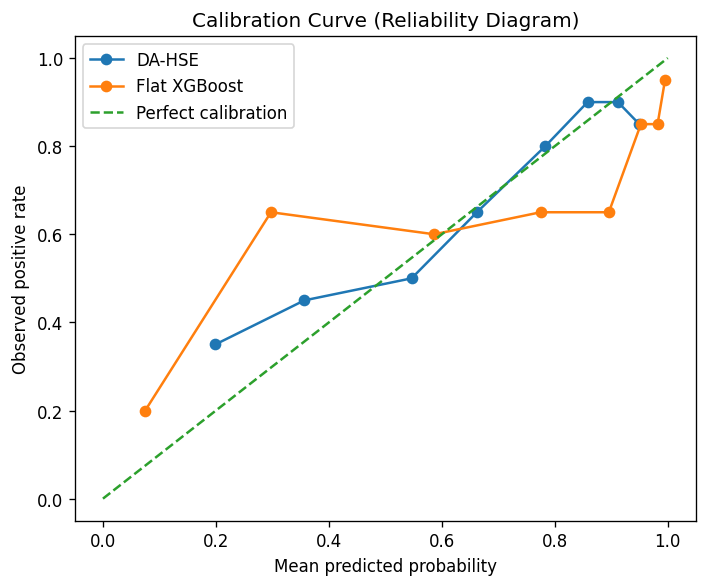

In [20]:
# =========================
# 13) Calibration comparison (DA-HSE vs chosen baseline)
# =========================

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Choose baseline available in your notebook:
# options: "Flat LR", "Flat XGBoost", "MDKR Stacking (DT+KNN+RF→MLP)"
baseline_name = "Flat XGBoost"

da_probs = probs_by_model["DA-HSE (Domain Stacking)"]
base_probs = probs_by_model[baseline_name]

brier_da = brier_score_loss(y_test, da_probs)
brier_base = brier_score_loss(y_test, base_probs)

print("=== CALIBRATION (TEST) ===")
print(f"Brier (DA-HSE):   {brier_da:.4f}  (lower is better)")
print(f"Brier ({baseline_name}): {brier_base:.4f}  (lower is better)")

frac_pos_da, mean_pred_da = calibration_curve(y_test, da_probs, n_bins=8, strategy="quantile")
frac_pos_b, mean_pred_b = calibration_curve(y_test, base_probs, n_bins=8, strategy="quantile")

plt.figure(figsize=(6, 5))
plt.plot(mean_pred_da, frac_pos_da, marker="o", label="DA-HSE")
plt.plot(mean_pred_b, frac_pos_b, marker="o", label=baseline_name)
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed positive rate")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.tight_layout()
plt.show()


## 14. Risk Phenotyping via Clustering of Domain Risk Profiles

DA-HSE provides per-sample **domain risk profiles** (demo/med/social/psych probabilities).
As an exploratory analysis, we cluster these profiles to identify potential **risk phenotypes**.

This section is descriptive (not used for prediction). We evaluate candidate cluster counts
using inertia (elbow) and silhouette score, then summarize cluster-wise mean risk profiles.


=== Optimal k Analysis (Risk Profiles) ===
k=2: inertia=72.53, silhouette=0.3724
k=3: inertia=56.42, silhouette=0.3076
k=4: inertia=47.85, silhouette=0.2975
k=5: inertia=42.59, silhouette=0.2524
k=6: inertia=38.92, silhouette=0.2488


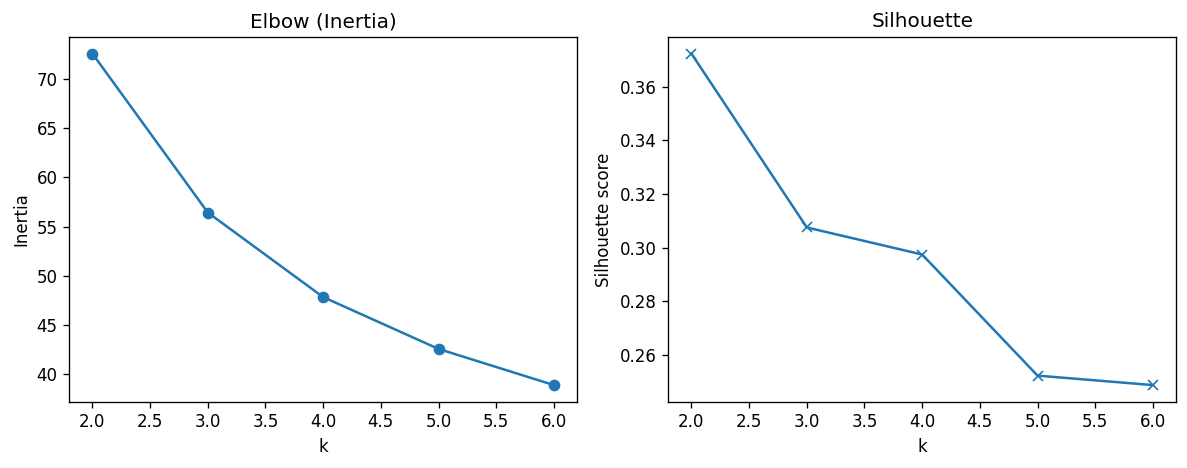


Selected k = 2 (max silhouette). Cluster mean risk profiles:

Cluster counts:
cluster
0    493
1    307
Name: count, dtype: int64


,demo,med,social,psych
cluster,,,,
0,0.603610,0.664613,0.744703,0.790404
1,0.543564,0.553237,0.459450,0.363963


In [21]:
# =========================
# 14) Clustering of DA-HSE risk profiles (phenotyping)
# =========================

# Use all samples for more stable exploratory structure
profiles_all = da_hse.get_risk_profiles(pd.concat([X_train, X_test], axis=0))
profiles_all = profiles_all.reset_index(drop=True)

k_range = range(2, 7)
inertia, sil_scores = [], []

print("=== Optimal k Analysis (Risk Profiles) ===")
for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(profiles_all)

    inertia.append(km.inertia_)
    sil = silhouette_score(profiles_all, labels)
    sil_scores.append(sil)

    print(f"k={k}: inertia={km.inertia_:.2f}, silhouette={sil:.4f}")

# Plot elbow + silhouette (simple two-panel)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(list(k_range), inertia, marker="o")
axes[0].set_title("Elbow (Inertia)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")

axes[1].plot(list(k_range), sil_scores, marker="x")
axes[1].set_title("Silhouette")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette score")

plt.tight_layout()
plt.show()

# Choose k (example: best silhouette)
best_k = list(k_range)[int(np.argmax(sil_scores))]
km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
labels = km.fit_predict(profiles_all)

profiles_all["cluster"] = labels
cluster_summary = profiles_all.groupby("cluster").mean().sort_index()

print(f"\nSelected k = {best_k} (max silhouette). Cluster mean risk profiles:")
print("\nCluster counts:")
print(profiles_all["cluster"].value_counts().sort_index())

display(cluster_summary)


## 15. Decision Curve Analysis (DCA) — Clinical Utility

Decision Curve Analysis evaluates **clinical utility** by comparing net benefit across
a range of treatment thresholds (risk tolerances). It answers:

> “At what risk threshold does using the model provide more benefit than treating everyone or treating no one?”



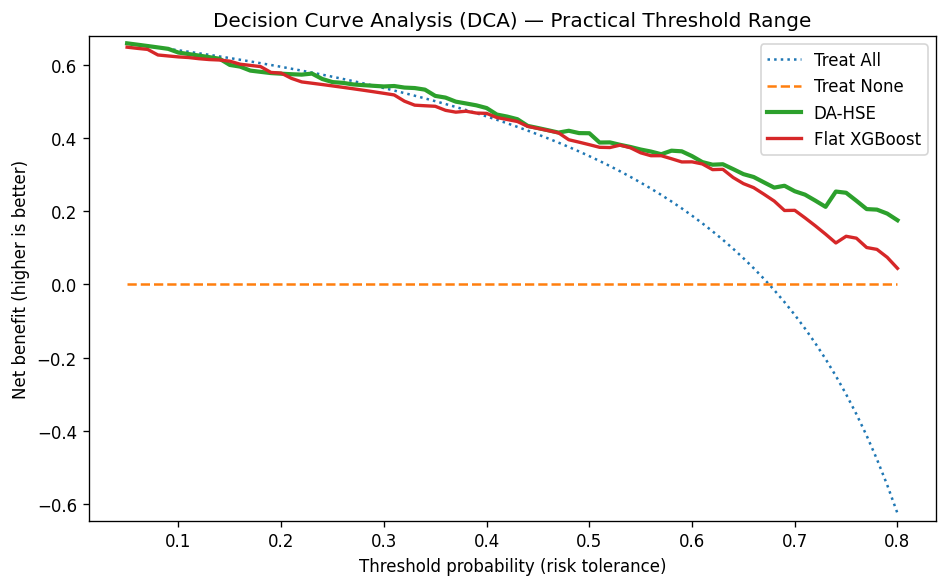

In [22]:
# =========================
# 15) Decision Curve Analysis
# =========================

def net_benefit(y_true, y_prob, thresholds):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    n = len(y_true)

    nbs = []
    for t in thresholds:
        pred = (y_prob >= t).astype(int)
        tp = np.sum((pred == 1) & (y_true == 1))
        fp = np.sum((pred == 1) & (y_true == 0))
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        nbs.append(nb)
    return np.array(nbs)

# Use a practical threshold range (avoids the blow-up near 1.0)
thresholds = np.linspace(0.05, 0.80, 76)

# Pick probabilities (use your dict if available)
da_probs = probs_by_model["DA-HSE (Domain Stacking)"] if "probs_by_model" in globals() else probs
xgb_probs = probs_by_model["Flat XGBoost"] if "probs_by_model" in globals() else None

nb_da = net_benefit(y_test, da_probs, thresholds)
nb_none = np.zeros_like(thresholds)
nb_all = net_benefit(y_test, np.ones_like(y_test, dtype=float), thresholds)
nb_xgb = net_benefit(y_test, xgb_probs, thresholds) if xgb_probs is not None else None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, nb_all, linestyle=":", linewidth=1.5, label="Treat All")
plt.plot(thresholds, nb_none, linestyle="--", linewidth=1.5, label="Treat None")
plt.plot(thresholds, nb_da, linewidth=2.5, label="DA-HSE")
if nb_xgb is not None:
    plt.plot(thresholds, nb_xgb, linewidth=2.0, label="Flat XGBoost")

# Zoom y-axis around the meaningful region
y_min = min(nb_all.min(), nb_da.min(), 0 if nb_xgb is None else nb_xgb.min())
y_max = max(nb_all.max(), nb_da.max(), 0 if nb_xgb is None else nb_xgb.max())
pad = 0.02
plt.ylim(y_min - pad, y_max + pad)

plt.xlabel("Threshold probability (risk tolerance)")
plt.ylabel("Net benefit (higher is better)")
plt.title("Decision Curve Analysis (DCA) — Practical Threshold Range")
plt.legend()
plt.tight_layout()
plt.show()
